In [18]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
import random
import csv
import re
from collections import defaultdict
from tqdm import tqdm


CSV_PATH = "esm35M_500k_neuron_explanations.csv"  
MATCH_STRING = "zinc finger"           
MODEL_NAME = "facebook/esm2_t12_35M_UR50D"
SEQ_LEN = 800
NUM_STEPS = 100
A = 8
B = 3.5


def find_matching_neurons(csv_path, keyword):
    matches = []
    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) < 2:
                continue
            neuron_id = row[0]
            if any(keyword in desc.lower() for desc in row[1:]):
                m = re.match(r"layer_(\d+)_neuron_(\d+)", neuron_id)
                if m:
                    matches.append((int(m.group(1)), int(m.group(2))))

    print(matches)
    return matches

# ----------------------------
# HOOK + SAMPLING UTILS
# ----------------------------
def make_multi_neuron_hook(neurons, a=10.0, b=3.0):
    def hook_fn(module, input, output):
        for neuron in neurons:
            output[:, :, neuron] = a * output[:, :, neuron] + b
        return output
    return hook_fn

def random_protein_sequence(length):
    return ''.join(random.choices("ACDEFGHIKLMNPQRSTVWY", k=length))

def sample_from_logits(logits):
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).squeeze(-1)

def decode_tokens(tokenizer, token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True).replace(" ", "")

# ----------------------------
# MAIN STEERING LOOP
# ----------------------------
def steer_sequences():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
    model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
    model.eval()

    # Load neurons to steer
    matched_neurons = find_matching_neurons(CSV_PATH, MATCH_STRING)
    if not matched_neurons:
        print("No matching neurons found.")
        return

    # Organize by layer
    layer_to_neurons = defaultdict(list)
    for layer, neuron in matched_neurons:
        layer_to_neurons[layer].append(neuron)

    best_sequence = None
    best_score = -float('inf')
    history = []  # Store (sequence, activation) pairs

    for step in tqdm(range(NUM_STEPS)):
        seq = random_protein_sequence(SEQ_LEN)
        inputs = tokenizer(seq, return_tensors="pt").to(device)

        # Register hooks
        handles = []
        for layer, neurons in layer_to_neurons.items():
            hook = model.base_model.encoder.layer[layer].intermediate.register_forward_hook(
                make_multi_neuron_hook(neurons, A, B)
            )
            handles.append(hook)

        # Forward pass
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits[0]
            hidden_states = outputs.hidden_states

        # Remove hooks
        for h in handles:
            h.remove()

        # Score: average activation across all target neurons
        total = 0
        count = 0
        for layer, neurons in layer_to_neurons.items():
            h = hidden_states[layer][0]
            for n in neurons:
                total += h[:, n].mean().item()
                count += 1
        avg_act = total / count if count > 0 else 0

        # Sample sequence
        sampled_ids = sample_from_logits(logits)
        new_seq = decode_tokens(tokenizer, sampled_ids)

        # Save to history
        history.append((new_seq, avg_act))

        if avg_act > best_score:
            best_score = avg_act
            best_sequence = new_seq

        print(f"[{step+1:03}] avg_activation={avg_act:.4f} | {new_seq}")

    print("\n=== Best Sequence ===")
    print(best_sequence)
    print(f"Max avg activation: {best_score:.4f}")

    # Optional: save to CSV
    with open("steered_sequences.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["sequence", "avg_activation"])
        for seq, act in history:
            writer.writerow([seq, act])

# Run
steer_sequences()


Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[(0, 50), (0, 104), (2, 451), (3, 67), (3, 200), (3, 196), (3, 266), (3, 316), (3, 342), (3, 352), (3, 457), (8, 411), (11, 392)]


  3%|▎         | 3/100 [00:00<00:03, 27.16it/s]

[001] avg_activation=0.1797 | MILNPIKMMLMMMLNNITMQLMVPNLCFDAWEMTVSNIVSDNYRLQKMIDGWHQAQLFAGRQNMMNMHQSMDDMLIETEMKMWIHFQEREGRSVSKAKRISHIRCLWREYFMDRSEHMIVNEREAFWKNVYFVVRNRMCVMMLMQCIKLQCGSARTGLDYDSKENAINIKLGRCYGDFMTIMIGNCPITVILLTGVGLKGMMQYQECGKIEYRVQHWLMFEVEGRHLGRKNWLWGTACNSCESGXSPQFTALHCEIPQTVNKDISADCAATRYMAXTICKQSMDDRLVGWAMKYCYRTNQTWTNFIMEILKQEYTAPKVTXARQIQVSYSQEAMMLQIMMRPQCREVSESGEIWIYRCAWGDNQMVCTPAQHCMWKCNVVGATGCGIVCPDQFDLLPGMEEMEVIFNRSSHMMSLPMMEFVVMEGDWMKKVTELGHMTLVKGKKXGWAKNAASGRLATDFIITKFARGFNFNAEMILLLMAAWGMSCWCGAMNKHNWKAKDCLNIMSDIPGREVLTEKLVLTIWFIANTRKIMHPDMFMLALMFMLMMTMMELAGRQTKRMIGSDMVEIPPSMSCLAGVFMGSLPMARGGSGPYPGSINGKVGNEIITNPRLTFKYDDTLEGDPPDWLLLGSLKVNGHRCHFMKRSEGKSDLDVFIFNVHMAGTYYREISHTAPTSRPSKMMAAIKDDATEYLLMYRRPGFAEKEHGYTCAQWADLEGMTFERQKNVSLTFLRGELEQRL
[002] avg_activation=0.1544 | MGDNLPDYMNQRIETDLHVAFPGEQGTSREEILIFMLCCIPIGMELILDECWLXMRMEEYRCGMDLMENENKVPGQAKRNGNNVVTAEEPNDAPLSQITMEKVIYMVFFVLMEPMMVMKMEMRGMLDKILTVLSQCLYGAMIEMELFGPEGLSYNMDFLVRYPLTLEIWVLGREAPECQRDMVLKLNQIXTVEQXRRYL

  6%|▌         | 6/100 [00:00<00:03, 27.28it/s]

[006] avg_activation=0.1423 | GXLEGEMPGIDGPQMDNLDTMYGMAPPIAIRERWKRLMHRMEPDTENMSPLGPSEWPLMELCMMYCMLFEKFFDIVTNKCALPSAISADMMSYPVLILGENVWSTAISGFIACGLRVMTINSRPLIADCPGWHTFFSQSYWLLLQKIAGPEIDHLPRQEQEFDYDCSAGRMEMMCEGMPVDVMTDPAXRNWTLGIDKVPRCXYPDMGQWVKCFVVHKKTFRVYYGFMIQIAMAEVTFRLPADQDHAITXIGSFNNSDEVLILMIVNLKGILKIANGMMFIGCGVWRIKVVRYVWKKIRGNMSFFFWVSEKFVWVADNGRPMGIGKWHENVVMGQVWYGKGTGGTVEPIISPQDISMXAMHVLAMVIWLNVWDVAVPNMIFYCLEENAFMIYQVFDDMAIMVQRMCEGEGQQTIGVGSNALNVYDWQFMPMSIHGWNSSLGSDILLFICFIQLVCQDCMMMMAVWMFYIVLMMFPIGKAGDQGTVRLMFPLRLHYNKDDVVCLIIRVGYKVAEKEVGVKMSVFDFDILILILLYRAGGIVNPNNWEIMAREVYEGSRGHMLQIVIKMIVDEMDMRSIDPRNRQIMRQLMMEEGDFTIRGSLSPEMPKKVKIPMVNLQLSLIMPSLFLEYCLTTMRTCNFIQFGMLVQQSQRWIIYRTKPRFAQVGAPEGCKQYTAVEIPQVIHSVENMLPKAKPEWNVGSEAYEPHDQSVCIMDNDEEKVLFMAAPTRLQ


  9%|▉         | 9/100 [00:00<00:03, 27.27it/s]

[007] avg_activation=0.1412 | MMMMEMMMLWCKSEGMRFFFRKLKHRGQQFDLYIGFHRVQVKKGFWCFPILCSISADGEDDAKEGKGVWRWGSIGAVYYMGKKMVVVLLLVAIEAGLIPVRMMMFCMLVMTGYVLPWQGEVAFTFVYCMDWLCMVLMRWWQIYKSFIIRPLSLYHMIETLLQMVSMGFLFMDLKYVSQGWAIRRYAMGLLQGFLNQGSFRCMITMWVWALYAAIKDWSALLAVGIGKLDLMTMTNVAHEVMRVNMGFARHQVFCKIGNGLDEEIVDRLKRIWPACDLIEDIAILMQLTTSQVEGCVARASNAARAQLREIPMCVIVGIDVCTQMEXITMTANKAVCRWDEEAGAXEHLGLVVYEDTDMRLVKDDIMPEAVMGKAMKQARLDEVMRSVMILLKCNNAMNIEMSCHYIIPFFMRKWCETEYRLMVMPRMAMTSAMDARIMNDMEAKASSVEGAMTRGGWFKGFRSYTRINFTSLNERRMHKNMLEMXALSTYFGKTLNSSRLQWAHKSADAVGGVVSKIEGSNVMQEAMLMYEXLMYPSMSMVNXGVGPRTWRQGRRPCNSTYSQLMTWATGMLVRSCALKTQEDEICHYQRTAIADHHLPPFKRPNWPRGGTMGDIAEDRLNFSATRQQSPPVLNSRLAQTSDSLQDDHLILYLELLSWLKDDTPIIRPVRMLNICVEDMITSGTRIPVDAVIIVEGRFVTLWRYVDWLFESSRFCNGKLRIVRSDKPIEQKLDLPQCQFL
[008] avg_activation=0.1672 | MESFPPVNRLSFMMLMFVMVDVVMKEKHQNMTIKCVWLGMGAMPFRREEQGQAWGDAQADWIRMMVKFINCMMKVALALILILVIFVCCFAIWYQKYWLSWSEGHRFGLANSHYSSEGKFKWIRITWSKEGRYPSDQLNVYLDVERGRIAYKNCLRGEQRTISSLCIKTLVICMMRFVILHQMEMRSLDKMMPIQWYAM

 12%|█▏        | 12/100 [00:00<00:03, 27.40it/s]

[012] avg_activation=0.1554 | MTFADHASMELRCAGLPMYAMLMCVRVQIVRYNLVISYMYGTIMEIKPLWNDMRGFMIRKGVRAMAMMRMMYMIGVYFVWHFAAAQAVIACMMMNVGSDDMQEQVTATLGYIGMMMQVFPQGGDFRLMESTQNWAFHWLIRLVFEELIFSSDGKIMLEWLLGEFNAVNGYTISTIMMCIPMQSFKMKASVNAWFSQGWSLKSSVEYVQGWHLTTSGGTGIPFIYLACGKDTVTWMFGILLGTCHQWGRPFMMQDNNAVSAEMLELGVMAMEYNTTMPMQAMRENYFGIGWPVFHKRASQGGFDNDLKVIQCSGSWDQMLMSAKKLVAWGISWGKPQAVRATALIWKAAFHWRFVKIVIFHIRFLKWQEVHGLMEAIVCVGMRWMRFMMSRPDKYWHQSEXIGRPAMRKMFSAATSXRHNYMRAKQGIMFFRWCIPFRGLLLLYXNEEGGMRMMRDRHRLHQRMKHVFVSLRNLLSIWEMQRTLLIQMIVTTFGIKRCFFSLELSTMEMIGHFGQMDTNSSDQGTVWLAQISEQRGLKEISGRGMMGWRLIAIKYFTFRTRQVWLSYGKGQYKMLKLIQDLRWNWLGVKPDQSGILHWLDEERRQDHYILFTITKSEFALLFFWMLKNQMLTREKIALTNAKASWAEVKDIRGIEGRMAAKWSFTSNQIKNSTSYRVLIFVPKDVAPSTQGKMAAGSLQRLPAVVPAGNFFPNENQQRDEIRLKRPEDDLLLPHNTPNKGTCPQS


 15%|█▌        | 15/100 [00:00<00:03, 27.60it/s]

[013] avg_activation=0.1679 | MEMMSIMVCLRQMTAILVLENVFRPMRKGKGYYGWPVAGGECSLDMDSPDMEMDFQHNFTEIMAMIHLVFNALGIVIAGTRRIGRISMQQMKHFPLRPILSRIILILSAVMMCQIRLLFFRVDLLAPGRSLFGVWVRCTVAXINVEILLWWKVVYQCVLVVGYCYCVMVQEKVFNQKRRQDFDIKHTHDHDLYIQWLMKMFYTVLADLDTAYLVVFYSFERRVSKTAKALGDYNVLEIEERPLLFLLTFVEAFRSLMQLVKMTGYKAQFIVEDWWVRLKAPLNQMGETICCGVSSDGMVLYMRMDANMNGHNVQAPSMGEVERQREMRCMVMECGSGAQAGDMMDILMMDIGEKSTGTDVVMMFKMMMDRNDDNLKGTYIEWGDAXLVWTVRQGDVLGALLIYLRALLVVHAAYIDLRVISSAIHTGQFLGPDDEIVIHIAPGVFMTTLMCSQDAAMANMGCFLDSACKSLLMDEKLLTRYQVKTKGERPNLSAELQSYYGAMVLVLDKEDVVVQGKNMAARSTRGVTEWIQGSILGRCRVAMARLSLLPTLSNLNGRFRQTPLYIPVTPIYAIMKVAAQARFACVIILGMNSFSRGFEYRNKRRIRDAGFRVIPQSWESMYISIDKLRHNLMQLRVALYFFAMMMLSLSFLWHGRSSNQQSIHIYCGMQQTGRDSNYRIHLGVQIFTGTLTETCTLFGGVNTQQPLYGSWKGNICPDT
[014] avg_activation=0.1447 | MIGSLVREDEARMMVFCDCRPVLLRFIESKWMMVVCYLRTLFWRKAVQYLWDDLVHLEGDNVFRMMRLAVREEYMMPGMMDMVVFISNMGMMAAMYMRIRWFFLLGKFFVIMMNCAHVLSAMAYIKFRTAIRMEIHDKMVIENAWMMLNGMMMMPDKELIFLKMWYVPFLLRQQGARVMAIGKAFEGRTFASKDELFPYPLRTVSCCXYEHMNRFSGEEI

 18%|█▊        | 18/100 [00:00<00:02, 27.86it/s]

[018] avg_activation=0.1795 | MMMMHKCGCRMTDDGKMFMMMSPAMYMYHSGLLGGYMWKGMDNGDVICMLTQFINEDMCYAMMSRFGSAACLLMGLVPVFGIMGATPKYXGGMEMDCFLLVAMIEIMVHFKSFAIFGMLEERREAPATAMACANSRQDVFDLSTWKSPVAPRCCMRDALTTXLGKKICAMPEXMMXHIFRLLPGLWDMVVFDYAGCFDCCSMIFPEPIYTFAVGLTAGDVIXHMMFILQRHXVTDLLANLDANMDISVGADSIWSLKMMALDLLFYSDVEGIGDIFXVNLCVVMMWQVGYFVIFVDVPMMIVLATCIEGFVKDPSGPVVMMMMHEAMMVIGAMMKVLGASCTGRDXSLEVNGSGISRQVICSASGWCDMMVKDRFLDGSGVMMERFFPFGSVMYGNMEISRFMIMYPFQYWNTLIRGIRSYHTMRMDAVPEMKXSGSVPVLFECGVRVASRALLIEDNNLARFNSWNLQAVRLLQWGCDFMIGELLDEFDVNMMMFISRKYGDQYGLLVFSWSTSQKEIAENMHYRTMSIKGHWRYMRLDAAMTVETCEMPLHNGIMNDNFMTQVAAMRNLCKKYPHXHFNIKNMKPYRPERHRDAGGLTESDLYPNKLLQRQPLEGSGFQIEKLWGQVERLEEMVAVEFTTDADDLAEENRAKGEIGYGKEVPKFLWAFDVGFDEISDYALRGHLGRSVWMRFLFLAEAFEFDAHDCPRNTWEVA


 21%|██        | 21/100 [00:00<00:02, 28.03it/s]

[019] avg_activation=0.1491 | MQRMLGRSFIXGKQNGGTASCAAGLRXLVGEVNMNYYKRMVMFLAPMMIMWIQSGGFVPRSTTLIANLGKKYLVXRTMGALAGRRNKCNVPHTATADDIGHLLQPISCPWIDVREGEFCRRIMRKLEVFGIQAKLRNLMIHIVSLQDGQVCPLMVMMKEATXTPVSEGPMSFKGRRLFTLWRQSKDCRIWQVTREMGQPLRGPYMFGCTGMFXEVCFGLIVVTGAHTECQVKHDGALQGCTGMQTPICLLEVQMQAMIMLSEMMYMMAMNMMVHALVLPXSIHMRVYGEVLDTSPVDTGVGDFCDCILGLSPLYRSIGQNKSIRINEMALMNNFMVLMLDMMWTAMMDMGAWDNRVILDMVWKNLHVACMGWNAIESQDEWLMNLTQLQWGGKFLMMVTITNNPMEKQCFRFWVKDSMNVNIQVMWMMLMNSAXWGLDQLELDDQTLDIDTNSCALVSYPETFEHVIEMMEDQFNTIGDTGLFGDGRFMLRLPCAMPRGCFSWVGKIGPRFQRMVMTDFHGKIDYWCNDERPVPTVEAIIGIAMDMMGRVGSVVEDMLMFDRPMKKGIPNPARTLDDIMKGSPATTCDAGASNFYVYAGVFWKEGIIQIWVGIRVMFMAVPESWKSGTPALINSGGKGMYENQVSTIEFVDLADVLIAQDCICTEEGLGHSAVHVEQVLFKQVVRATLLARGILNTDQLPQIGYFKPFKPQLSKLVTNRGGAKSMLFGG
[020] avg_activation=0.1567 | MTKVAQKGEMRPRXYQMWQFSWWISRQNEFRVKGLTVVSKTWTTLCHCLGIFVAICLWSLITDDMVHRMPMILTMLEKEMMDMMMMTDDFVGYKIQLRPTGQQRGECIYLVSRANPKQSDELSFRRKAMTQFQQCRSRGYGEAKPDNAAWSSDYAKNKTKMESDCLLRERQDVMMQATPVMTVQNMEQMMPMLITAXRQVLVIFVLEAGT

 24%|██▍       | 24/100 [00:00<00:02, 28.28it/s]

[024] avg_activation=0.1440 | MRRCCGRHTTMKKQLWVVMTFHKLMSKRSAIILAGAQVNLDFQGINCRMIINSEHDMVVMMMMRKTMVMNFTQAIIIFTCLKVFKLFVLAKVELYESLMTGIFDKFPDICYTCMMMIGLNSSKHSGGIDKAMGTRACMITRLCRFPVAFRVVLNDPLFETWFRIILCLTAYGARGFIDEFEIHYGFTFECYHYPEGFVWLMMLMAFNQSRLGDEYEEAFPLLAMTRIMQRTKPIEKPIGECIEEGRSMIFDAFVTRGFKRQIFYFGLGDDMEVLDDEHTNFPNGPVITVLEVIVYWIWVWAAVRASDVFLSIFGNHNVDTFMMPRRAEALQFPMSEGPTQTKMGTDYRASGTVNNGACWQALTSSFVLQLGRIWVWXARLKSRLEGGFICFKYLNHGANMRTIVRKNSGQSQRLRVQGDNLLEVERKAIKVLEMIAREAAHLSEVETKGIIKFNIDWACYLIAQXTWKYKQEQHHQCGVPFSSDSYNLNELFIATFMNNAVSFHFRLNGSVGEEEYGTAIXYTVTSLWVVSDFHDGDPPIGDLSEFIYKQCWWRCELTGQKIVSTGYDVSGDDMMFYSFVFGDVSVYMRGYFCSNITLNTREERPWEDIWNPIATFDYQLPPKPISMEEAICQVHLVTMNISARMDIGLLLIYALLLSDLKNKLAHMYTEKKDLSLITGFLRIASRSNCQNFSTARQRDFNFDTSEDIVEESTEAEDRPEIISWQSEYKLGGNEGPTWQPSVPRHEHEMDMDE
[025] avg_activation=0.1338 | MMAWMSYNPFLKEVGYKHEWYRYGCMIEPREPRKMNADNFGMMMMMMWLGDVMIEIDVVGMTLVGAFIQWPIALMSDVGFDLYFPWSFKIWCLGSRHNRRIGVARGLIEEEIHILTFEKINKGIKMIKIAQMESAAPIEDVGGIVTARDKKLINGPMPQWWNIFPGLWDDRMFDQPEDMKRLMLIR

 27%|██▋       | 27/100 [00:00<00:02, 28.48it/s]

[026] avg_activation=0.1442 | MLGMPLVQTIHGCFDSREKPEFVVDMMEDVIKKFAASDTEEIVGWKHRRAPTAPQMKAIGFNFMLKKPMFMGVMGXHLVMDANLMLVYXFFELSLNGGGKMMQQIMSVLPRMVHAKRGNYGFXENWVVENLRAEGIAKHFLENERVGTMQYGCDFKVEVNSQIDKKWLLAGGLNLILIFTVAIISEFHNYVDSVRKAIAIKISWTMELDMPFKELTPVLVSVVISXESFLWNRRRMFMGSYXHEITNAGDRMSNVPASPDRAMPVAMMDVXWIMNIKRSGGAYEFWIYTVNGNFRVLSQLYHEITDSSRFYARRTMACYPLXSMLVDCYRLMMMRGDMAMMMMKNAWMILQFMTSKFMFFQLIFCRQEDFAQRSGDLVLRYELVDYFVCKVVSKYAFEEFFTYQDGARVQMRARTDCRRFTNQCSSVEMVMMMCYMMPGDYFGVENSPMYSEVFMQLICMNDRFVDARLEMRIQIDAEMMGSNKMGMQRRKRATVCPPDVGKGKSGWIEKYQASLEIKVISHKEPTIESATRTGLRLQRAFSWSALTLSDIMVTNEMASFMMQMEFDGTIMFMPESGGRMSARADTFAFGNKYLLDPALAGNMEQQKRSASKEESIRSKCLITEPYGALDMEYLEIPPQFSLDQYIEREYIPASWPMRLLQNNCKAAGLQVTKVQNRSTLRIPSGIKWLPPTKTRPNFPIVGTDCPLWGGVDKERVRGEKEMFTLQKDTSKKQEKTVL
[027] avg_activation=0.1484 | MSRKPAIDSEPFDRRARRVGANGGPEVEVQVFLAKIAFMLLDLLKMRMIVRGGIENFQQEVSGQRRMQRSQFTDEMLGKRLSQNPSSAGIVTWSPFADLPMETIMMLYEQLGGVKEEWIEVQSELACYAXMAEGKSNLYPMYASKLIWLLGVAGGIILAGRERDPDGGDILDSGSLRGRNFTREESENRVYQLHQGSLLWK

 30%|███       | 30/100 [00:01<00:02, 28.73it/s]

[031] avg_activation=0.1554 | MTSMMKRDKXWTQYLADNPAYMLKEVLQDSDMMACEQVSMNPDFMVTADPCRKGALDQTAYMCALQSVIPVAFQLGLYHMGQESMSLXFLGSADGKPFSAGIIPRAIIAPVAVTLTPNXMLEANMMTGVLVYLKRYIERMGIQALIIFRIMTCGQHEARLNHGLAQWDQEDGSPYLHIERLQRDEFISYMDHVNYIIGYESQSCPAQTLGLGSGMAVADAMPMSCVLSWWNLQNPFESVLVCSGRYANVFRIGVDRLCRLMNLESSASRAGMGEMFVGNTQGMVQCYRKEEGPXGADPEFMMAQNYRKRDCDVNHWQTWVLLHNGTLVXQPDDYQEAFLTFIREKEVEGAFWGGGGRYPSRYVPXFPLTKQQCELPYVPVAVAVGVTEFRGIGATRVYIMTNIHDTWKYIEFNCLGIYHIIVIEVPYRSHGLHMEIQCFDIGGELDIDDHLMVHLGMSGGISSQRIQAHVMMMMDIKHRMPLHIVGVQRNNQHFDMQEYYIIGSYIKAKYVACGGGDVSEKEFLLSEWHDKTMGTDADQVNALCPGIHAMQMGISNFYHPWSYIGNKARASGIVKLSFHGISGKDVTVSMKKNWNTWVPVKHTNAMDGTVATVNKILCNEWGASGVGTMPVEHRDIGIYGWGTDDGAMGTLIIENHPIERKDEGQDKIMRDFKRAKKQVAEQTWDRYKGYHPEDPVRFRMVDDVDNVDEFKLGWPGKFSIGAIQELTQVTCFNVEFPAIATNPN
[032] avg_activation=0.1714 | MKCSAGDLGVWWTMNSNGEPADVQXMLRKKTAMIMFMSCLFSAVQFRQGYALVISSNMLNRMGEVGSNLPMLGIGSGCRTACHTGFLGFWCNLRVLPVGLDLVVAAAILXPXMTKVMALMFKKNSEELKSYLWVIDGPIFDQSGMYNYFRLCGDFFQLFRSAFLRAPFVVHLPNAALLLKHMHLFWYLTKCMLAD

 36%|███▌      | 36/100 [00:01<00:02, 28.94it/s]

[033] avg_activation=0.1787 | MGFCDGALVDGMGYFRADSRPEGMNFKXWLVLVMDMEYMGPLFTAMLCRMSNMFRKTKGSWSWFRINCRVEHINRFLKPRNQVSECNDGRAVHFARLKNLVVSWVVKMIMLVDICLNKVGITFQEVDQKVKQGLTEVKAWTKMCIEMGRALIAQFEGMDSLEFRGARKATPHNEIVESGDFFFWIDLRRKYQRLWYACRGSQDIIEDGHMDRYKARTNLPQLNVWRGAGSKRMRGGHDFDPLSGWAQIKMVSCTGVLAEPNEGFACIINMIRTVGIQLGMMMMFEMEYRIGNWRAGLSAGALQTLICGLFGQEPAENELWSLLTRKETIRYACGVQNGTWKLRGPLGEENMMSIKNECCVFFFMSFGVASFGKAQWLTNREKVSINGQMDDNRRARHEQRNKNGLIQRLEFEEQRNQDKTGDERIGIKDLLFRAKIMKDHLMLGMGRGPAHXPRQETAGQRPIRAKVRLRLWPFHCLIFGLCRGYLNHMRQVNHHVADMIVLLLWEXIGGMMSIARKDKDELTEGYQVNLGYYAMYLRTIRXAGCSTIQEIFMPCMMVMYFICITSWMCPWRCMMMKTAHKMMLYNLSNVKCGTFGKKQTSGKEKRLLLALCKSDSPCQFHGSGALDFADEKAWDAFQCAQTAIEWIAQKTDEDERRTVTFDLIKETLINDNFASPPNMGERSMVRSFNTICNPVCIREILAFPTYYFVRRRVKDKADTPFRILLLSQGSGTTAVLQACKLAAKSTAIEGR
[034] avg_activation=0.1679 | MEAMMDIFYVFTVTEGQIETDWVVWRFVVMSFVLAAFWCMLILDEMHMVVERIMEENSEVSMTCPGRDFCDRMKLLMMCGKLPRRGRLRVYSVAVGDRMVFQRAAIVSATEMMSAKMCLVGLTCFQFDQCKKWTSGDGRGILVLYDLVYARKCRRWKMMSKIKMSMMLIWALMRFFYCAWFMEIHVSY

 42%|████▏     | 42/100 [00:01<00:02, 28.99it/s]

[040] avg_activation=0.1599 | MKGGMPDEAVLIGVGLHVVPPLIMNVVAGATRMVQPAVRKDDRALXVPEGMVIMAPYKVALAILLVNWIVFLVMMVVFYLLSFEIVSFDCKGMHDFAARSQWAKRTMVLGCTGLEIENDSGVRGNQLIMMTCMRARTPLSTTFMEWIYRKSPYASVQIFKLFCKLKYAYVIQEIMGIYRLKIRQQKGQQMGLWHVDDWQKRWKVAICLTKNWLFSAMLKGLYKLLGHNIDVLNFYKYRXMTAMFYTVEFKQTATHGVSTYANNRKFDYPHCQPKFVEDVKMQDCXIESMFQVKIGDSKKRNEYMDRVLMVAYPTEPQDGDRPIFDTRRLEKSXTNWXTLTGDMGRSMRVLEKAFMFYTEVIMDWMTVRNDRLPFEMENYCSYICLDPRRSTSAVYMIMYSAAGATTTTAMHYYDQNKMVCLVKLREHWTYLAQNMMHKLEXEIVEDDRPGMMXLSTFFIESRRNVWLASVTXNHGSAGGMNTAVERGKISQLGVLEQGDRQNVEMFMNWMWSWVVAMYHKSEPNSLQPKNTLRVNIRTNFPMDTPFCVERVKGSPTPMYRKKQNVLHEKIFFKSPFPFLCGKSRLKSAMETNYLMXMPDEETGCHKDRGKNYFLASVESEDDMLTEFDNQKVAAGNKQGHRMHPEAIRKMVYSQCEVGINIVKAYKAGFLKGHFGLENSVPSKRRDQDPHLFEFTTPTGISTAAAMWMGVWRIWGKGKMRIMRQDWRAFFFVFVLAQRKMGL
[041] avg_activation=0.1486 | MDKMFLSRMAIAIFVGSHAENSRLVKFAQXALVGGIQFQEYQINRTDGAMDFMNVGQLAVDRYRNRKMRAVLPAARWLYDRRTGDRTDQKGWNQPKPKKIVLMAVFDVRVITIAIRISGQMMACYAWSNECPLSFVLFYTCKISPSGQRRMKYEDVGCCLANNKKCVEMPMINEVTHTTKVRIRLYCAVIANRNMME

 45%|████▌     | 45/100 [00:01<00:01, 29.00it/s]

[045] avg_activation=0.1656 | MKMIMRAWYFELQFMDVSMEMCMKIALFRFFNLDPNGNHLAIKMDMYEKLMNNMKMLNLTGSAHYVVMEGLQGVKDMMDDFVPNQLILELLFDFGLVILSMDEEYGDYVIPHLWMERNFRKSAMTLWAVKVFIYTSLLSVKMALNLIMILICRSFMGINGTGKMTGNGMMLEFGNSKLQLRWQLIQKSTTMGWTAAHRGDLGLKVIKMWDASRSRLETAFNNETYMYSRLLIREYAVHGDAAKMWKGWFLWENCLFFAQPKFVLEVIDGGPPTGTIHPEVMDVXVXTNRGRVLTGDKTCAYLIYWLSWNLAGLTVGKSIPRIRGMICATTQFVRDPNSDCTMMDMMDDEEASKAAARTYQPFDIMLLMRQNWWAPFTGNASISYESIVLMGVLWQTNKHVKIVSLVEFHADDDRNMVSRQEPDTYNLCVPELVFMQDAMMMEKRYIKVQVLNSEWDSNLGANSCGQGIPFRKEMPKMPALSSGTQAAQHIFNCIQIRSIGNPGEPYLYGVSFGQILNNFPGGKGPMLSQRKPACTEQMINQTSMHFRPRPLKLDNPSWEKNTSAGGEQCVYFDAAPAVSEGFMVHTDTWLIRMRAPALILLALTCDRAAAGFLCIFWIFRLVIISARYYVWEGKGVSFGNFADLVNIVTPPQFMHGGTEESLTYYNYKKPNPYVVTYNNTMRDWAPGGTNRNPAMIVGQGLHMMDYKRTVIASEDDFGDEKKHGPCSLTPIFDSGPAQVRGRC
[046] avg_activation=0.1735 | MPMLHVGMAVMMERLANMGMLTNVIKDHATNSLFIRWIMCMMMVADVMVMFACTDDICHTQGVMMMXCFGRAGRLRRAQDLHCAIMMMALMRLVMRTAPMMTMIHTHEFEVAVKEFMKXDAYQILFCFLLFELDFCNLGLFVNIKFGSEEEWHDECFARRRRYSEMMVSRCLRLIIFHANLMNAMAWGLAARPSLP

 48%|████▊     | 48/100 [00:01<00:01, 29.01it/s]

[047] avg_activation=0.1732 | MNFPQRTMAQHMRFFALYMLPVCNRHCMVRMDFHGVGIILVYGLETNKQVDFDQNKMMRMCDRKYLMMKERGVEPMEGGGPDDIMMEIVVNWMLLTLNKDYFDVLYVMMMVLWQVERKVVNIAEATGMTIRKGDPPCIEERCMMSIMISRKKMLNFNLTEMENSLKVEMIIAVEQIGQWVFSDLFGKFDRTCLLTVAMQDGQMETCHDMLPPWKLIYPHGSLWAAMACGDVMASGRVYYLTGSMKLQRRVSRFMRRFGLYIRNISNGSAAGTISGSWGIVDYRHLNFWVTDIMQDQGAHVLWEMVRGLDPVQAILKYLPQWWNCQKCGFVRVNQDCSLFETYTTLLWANCKDITGTMALLMMELKANWWFLKATVTTNVIKENFELTISMQIMMMVDMWEDDDIGNTIWTAMNQISWVFDQQIVACFNEQHLKYDMTNICVVSEIDALFKMKFVSAWFYGKNCFSADGWLPWEAMNQAIDKPMQRAWRHGEVDLAQLRERQMWRRCRCRDYTQLEVVWHLEMKIVALENKCDILCLICGMGLFELTGVEILTAHQPNAICIAAAGECDRDTFPPFFAVTTEAIDYLITQLCWPGETTDHFLHTEKPCMAMATTYSMTPVWREKACKRDIHHLYGVVHIMLMCNRANLRVFMFEVSTIQMRYDETIFSCLIPDIGLYMSWDADVRDLRWNMGISGEANLFELDVELLYGCNVTNVLDTQQKHLLKVEAPQKRASR
[048] avg_activation=0.1518 | MKMEGEISFAVLTQKLSMEKLLTRALMNGLIYFFINMMMIGFVLWKLWLIRPMWIVFCLKMDFPDEKTLVTGGIMWCAVADTMMMMLLWPKWEHHIAIIHLIKPLRRVVTLYLRAXMGYIIEKRLCWTDHFSGMGQSRGAEMMRFLQLDLKCIVMMVMAMLLVAMKMAMTMFMMQSMDCLIRVLRNHTSDKMTIDPLYEIDYSCF

 51%|█████     | 51/100 [00:01<00:01, 29.11it/s]

[052] avg_activation=0.1570 | MAVVAWQIGLTMKLALMAGGLMKVSGEISEMVAGTGWNAFMGHMGTVNDKMVCXVCFHPYLCLNKGLACGVVYFELSMMEASNRLCMIMQGQKKWFLLLLQVINGTRXAIVDGLCQKKNDHLGLSDSVQDLMAVPTMIPFDMXDVTXIQLTSNGIFILAILCTKYGFLWEAMDNXILMITEDIPRVFRKSTYCAKGRKDNIMPQNYIQIPYEVWPDVMMSRSLNKMVNKVSLRADGMDPNTVSQKRSGVQIESDVLITAAVAFWFRLLHEQAIKYFIQIWSGGGWVHLTGKVMLEFDLMMDMAEWFMNILIDVPRMIKKNLPAGNFCSVTVMQHIVADFMKFWYASLKFNNFNFEGEVLIDTNFALISMLVMIKMVLMMLTLRVPQIINFLIQGLNAAKGAACGEMIQGYGKDMNGAWYELPKSMDVMMTMNEISNISFKEFMMCTMINLYVFLRTXSKIGALVYVEKTCDTLVLLEKCIGPEQWMCNAIXMXIVNKYKXKFSSLNGSKHPFDLNANNFIFFAQWFCSERINPFPIKFMMARVAQIKKMGLNLSLMMKEVEMDSGVMIQNWMLLEGTMMDAMFDLNDKLGQLKANVYNSRKITLCMQDMDLARPACVVSEEVDIDNFGFPKHPCAKLEVAERLMMVDKLNKQYGWKKFCEMVNAKVCSMAYMSRFVEKGNEAEELGYYGRQYCTMSYLPTPVTGESHVPDAIRPVTQTIGKVK
[053] avg_activation=0.1411 | MMMVXLDIMENSVEEMMWFEEENDGDVMKMMEAEGQXLGGGMVLETAKMDDIIMMEAFGFNYDRKSGSLDMLFVLICLGIVVVNVAYVGMHMILRMIRRWFSVLYFMMKLVLAVKSRLGIVPFRVRGERTVLSSVHQFQCRVATFMVFRDVDMMIVMAMVPAQMIMQVYRCGWKKMKWHRCLIEAATDGQQTMDLMTGVPPKGMVPHVSSKIFLDL

 57%|█████▋    | 57/100 [00:01<00:01, 29.16it/s]

[054] avg_activation=0.1559 | MLRMLLEEQGGRQXTSGSSPLCRRRPGSHYRPKQFKCSTRTSACLKAILMSRWXSNDXTVTKVNTPPGDNRGEHKXYKEGIITKVLANFQVFGIRIVFQSPILEDLGMMLEVLNRDMVMGKRNLMIFQVEGGMTMPRFNIGAQDFFPVAGLRPDSPHHRVYTLPPCTPVSLPANEYRSYMFFTVAWFKLGGVNLEDMGGASKAXLTRLDVEVDELMGHVIIAITSKDSPKSSDNREAWNSFRALVPNMFHNCQDGPESDREFGKYQSKRVIFINAIIVWMSLLMGPLAIKELAQENLMILGQCFMIRVWXRMVTXPRVKWMRCGKMYKTFAQVCKVVLPLTAPGVVMCIWMSCLMVLPYQNWSDTMEEFMKTRLLIFPVADGDFVTVLSKAYLATSMTRLGFLMFYDADIGVFCRVRDTFEVNDXRGCMVNGPRWGTGLTDMTNVFPVKKKERMEKNFDQFIRPQAFFSPSGFMRLTTNYMCLMNFVIHGVMTWVRSIGXTEVCQLFSFLGGFRAPGMRRMDMVXFCVDVLAELVLRSWGQVMEFKVWLYHSNELGKGVTDIMKKMLTCNNRMRMANMVMMDRMTPSTCRDWAQQIQPIILRWHKGMWESTETRFISPTLACILQFRHLSHAMVVKEEAAKDTFAIFGMVCISSIKEISDFGEPRKRIAARPYFLNKKIAQNKDFPHRGPDEEKYNGFAADSLVSTWQRLESFCYLYVHKQISGTVFNFTADPQTKIKEGKHTKIREIEYGNHARYTDLY
[055] avg_activation=0.1611 | MNWETMGEKRDRERLPILAADKRTSRRSMNAYLDRFKTKEDGXSTKKAGPAGAALQTCLIAFAQWWTWNDMMMMVRCSLIAQENGVTLPCGMQPMMSTGANFVVHVIEILWVDLRLEIVDYVQDILQQTFKIDGSTGKYFGAIKCGCSQLVDLLFCAAKPEERMMGESLDDELADVRWN

 63%|██████▎   | 63/100 [00:02<00:01, 29.19it/s]

[061] avg_activation=0.1490 | MKGTYGPQRSLTEVMAEKRSIMKILGCFGYITQVYQSIRMMLAKDDXSMMLECYRRNYAKHAKLFYVQILEXAHPGMQMMPKMFVMRPPVRKGYGPMIFEDELXNDIQGIMAGIPNMLRSNEYSGQKTSRTMLVNRFMMNGDYTGTARANIDGIAQKKCTRRFQPMCHCSIANLRKCMSKNNPHSYIAMSQYRSCTFLLQGMKFALALGSSIQERIKEQHRAGFQEVWFGYYIILEIMVLWMRPTAYMNEPFMGNLTVVKSPVGLSCMMCHFRRNVFHYALQQGILPRIIRVCNFRGILEGAMLDRGLTLNKVXMFTFAXKATVFWKVTKQKLVYRLXLENDKKDKSHMSNEVVIDQEVTRMKMIMFQQLVLWHREMLGRNGFAVLQDWQEKDFYIPDLRTVYIQLAVFIVTNQTLVDFLFELDQMLGSPCCPPMGLEPVPLFDYGNPNARMFTPMRIGQVPGLWPVKICSLPGDFKSAAVCIGDNETGAVADKMDMMYKQRLGLQMIDQHVAEQFMQGICGQXNGSVMMMSQYSGIRSQMNVTGNAFQQYRGSQLSSECMMNRLVTSGNMFPRFVRLWQKREMFPSEHDKECIGKRTGGRDEHCHARHDIEEKVNTIRIPLNGHYQRVLSKGGINGTIKKKTLWTMMISISLRYCRHGRLATTASRNFSMRHKLDIGDYPAVLTADSQLKRPMSKDTRILRIDQAHEEIGLAIYPTFLQPQITEMQSVSIFHLH
[062] avg_activation=0.1606 | MKKMTGRNMSLLVPFAILLLIFIGMCHLLLKRINTIMTVSICEALMLMGDWEHMMMWYLYGTGLLWMLGTGEGMFISGNPHGRVYTMLFHHNNQRXEKDVREMMMFYALKRMRQMSADFRKWNCGALAQSKSFMVRAGRAAVEPIACRVLMLGMQSFSKLDHRRPMNAVLGFQRRLNAYNEAEQTMVCLAGWWGKDRLAACTYV

 66%|██████▌   | 66/100 [00:02<00:01, 29.21it/s]

[066] avg_activation=0.1378 | TWGKYMIYNHYILCGDALPVTMEMYRTNDELQGCIMGTCYLVNMNMAQMRGVGIDRSRPGGICKFMMVTFMLDCMRLVMMLLGTVAAEVCPXLVPFDHIDVKEGGGMPGVAKNEEGQAVIFTHRGWNLKARTYYGKLMTLLWNNLVLESLEPYVAGDSADQMDCGASQMMYGDHVEVIFMDDWQQGSQKERRLWHNTLTVAMMLRSAVGFPLVVMPVMKEFCQWMKDPCMAWSIKRVQTDDFKDIGVCMWWAKIAWDMQVIRLMIKHRVPFSFGAPYNFVGLGSLMPIVEKDFDPPMMDDQTDPTEDEWYESLEKGFCALCLFINCDFDFSVRPLESMXDTNLMHVMIRAYFIGRGVNMEEGQMMCMNIVSATGIIMVYILPIEEAEKLEMAMILLNINRRTRLIITVERPPDIGASAIKNKIGILHIXLVLVQHAREMVDMLKTDGXMNEEVWTDELSTSMQYFENNIGDVISRCMLXMLMPTMLFLVPAGTGVYFMMQQRQXKVMSVXIGDGQSVLMKFQSNIVYGRHDFVPISLIVYSPVLLFMIYMKRMNTVNQGNLHKQPFSLIDTFSIIFGYKMYLKKPYRGWAQDQGLLTQLGRIERFQYKTSIAEYFHDTTIKNSEESFGGGGGAAAVPMFLYDRNMILHIDIHEPFNMNLREFLAGKWVMVNIIFQHEFNQSTILSKISGERAPVIGPGLRNHMCAQPQGRFISGKKSGSIWC
[067] avg_activation=0.1791 | MGLMMADLAGMMKGSPVFDVLMWAMMLVRMAQEVPKMRLVVLGVNKDMPLLVHSPQTTQPVVEEFIGFYPMFMPLFTILLCAMPWMKFTDMMSLVEPESFWDYMEIQVLVPYVVTGKRSGNKQSQMAVYDNTRRMAGMKEMKTIRRAQVANKLICFLTVLNCCIKMLEVVXLSRVPKDSNTMYPLFSSETLIAEMVDCMDIGRQAATSRRLGLCMCL

 69%|██████▉   | 69/100 [00:02<00:01, 29.20it/s]

[068] avg_activation=0.1761 | MVSMMRFCIIKLELAWLMTRSAERFLFAVQHTGCLPVRGVMEYVLNEADCTTYHERMMQMEMKAQTTVMNTMFIFKKVIGLMLCRQFFYRGRRVILWWIIIFPINCREMKSAVSAIQLARSIIIGKQACVLLILNMLQTTXQTPVFWAMIDAGFQHIIIYRWIVMYMIGVANFTLLDMDAMVLXVTMNIICWVLLNFPELTLMMERDQLIMEPMKKGAAMLHQRKTHGSKNTSQLGHFRKSHRFQMLSSKVMAVPHGQIDEGYEGCKQVARFFIDLKKFGMLRWLMRDEMLKQMLGIRRICFCIVTSWMAKFKRTERGVESMMADLGVDCTMFHKMRTRGWWVKYFVMLGAHRKEMFMMLMKMVVMTTQRADEFDCKKKVVLTAISLCRSGFDIPDSGAVVCMMMYLQMKVALRVQNMCVAFGGVLCMMCNFRPCLGPIHFGDGNFDFIMLDGSFIWAYLFAAIRGRPLYAKSLYMPTVIXTILNLLKINLGQLNKSESPWKVNLMISGRFGGYDRDLWSCDCINRMTMMMYNMTXRKGVVVVQPRRSIKQTATVFIGLANIKAIGWITVRWGAQITLCMLKFYFSIVIGMGKRTQLEMSYLAPGDGVQQWGAMREARWDLGAKKPLILQAPRTEAFIDDREGVLEESTVYMPEILQLEHVIQMGAEKTGEVQLNVAAEFGKVTYRFKKSAKKVVWFHFEFTNKLSVRNRS
[069] avg_activation=0.1690 | MMNMELEATMHVLKGEDIKDRLLLDQTFGDFLDIVQVMTRDMMQHGMLIGSMLAMMLKLTRMAKIAGFRIEFHVDIIVQDVLRVERIDMVTAMWTLRFFMNAMKGLSGREQGFMLVVKRMEAKDKFSRPFLLQIHRLAIANQLFMSXMEIPAYGLMCXIVELLDICLMWPRQSTKEAGRADKAIYRNLEPYAVICICAELKTVYGVFSYSLEFMNSTFRNTWSIYACW

 72%|███████▏  | 72/100 [00:02<00:00, 29.25it/s]

[073] avg_activation=0.1588 | MPVLTGALTMSIVQFELSLGIYYAGQMGLMWKVFQKLEDKLKNLKRQCYMWVEWLVAMMMLMLKDRLQREFREVGIEASMSILGICGSSQFGRIKMQKRPWMKQSMEVGNSQLNTKNAKNVTHPYIMKNEYEYISMVMNIFNIIWPNVGKTGFRXITAGMQAYLWRPALYRAAFMGTSIVPVPQYGDLMLNFDRQQVDSMMGXRLDIKMRKDGLLCFSMYILYFRSWEVRMMRMDIFVSLLMMLGMLNPAVTFFYIMRSYSEERVTYRQAKRRLGRIFYQDPFFRHLRPCPCRVMFLTCLKLVMMLDPPHQVGSIFLWIGDSGITDLGFVNCCYIIERMDYRVTYSYRWHCEMXSLRLFGDQLAGAKRQTLRMFMYYSLKQDARMKMHPPACGKLNDGDERVLDLWDNYEPVFAKFEDRFFIMQGLQTLTKPSDLYNAFARWIALSFAMCIVAIFLIVMMLKPLKDVVGFPVMQLYMMEQMMMDFWMNLTLMKEMEIDFLMGKNGILDALLCVVVLKAQHAVLVLEANEEMEFAWVLGQKCAQHKDVVKMSLAAQSPFHYELLDVVLMMLGRRAKHELFKMKASKVGGMMASWWGVEMKHGQSIDLYTLQVSVAILQDSKILLNDEDALSRQTRVVAAKPPEMLRPYCDGFSGFICDGQSIISSRCSLSFHCPCENCFIRIRRFEFPSKLGRTLVCSINQFAKATISILTLQAQAMIAIRKWRIQKQKNSKQKKLQNHECEHIQIRVEQQ
[074] avg_activation=0.1647 | MMDMAWMQMRWNAAPMAMMTLFVLMLCEIRWLDGVMKTMTTQLDKLCGSMYQTVGNVLSMTMMADMDFVIVELNMNLDGHKQVGGXVKMVLKELVMEDMYQSVSNLFIFLIMEKAMPIXYVECLSKKGWNWGYRGTLLIFRIMDLGLCQEMVIKVYMRQEIVIMMHMKMEXMNMNYCTAMAMTKDDALC

 78%|███████▊  | 78/100 [00:02<00:00, 29.19it/s]

[075] avg_activation=0.1586 | MKSGMNFVWPHRIERDVMMMDTEAAMYMMLMRAEMDSALKRGRDWYPKVRAGLLNSNLETHGFYEDRTRLHREAFRLIVGEEHRVTMWDTPDDEGQQGEVAMMMVRMMKVWMCAQMELVNIRAKTVDMMMMMMRLEYIITGCHGRTTWIADLGETNMLGEAICPQGCHCKLGYRPRRMQGDLQRQWVNGNIMNSFYLKPRILQYKILGLRDVLGIAGLKELSHFFLEFFQSGGVRVAVAMGPTPGVVQNFYINLCCYNRGFVIIVWNRSRQSSFKWLYVGVFHVAGMNGMNIFWRIRMTQIIRLALGGDNYVQAKAGRSGYFKLKLMPNGAAYTKVIRCSNHFLVISLWLTCLRLDMHARSLTGTAVPLILTMVKGGEGEDEMNHXDHFQTRCGNNRMGDDLLLPEWDRSGRSALVAWEVLMELRVIGSHLDVMLVFEDMMGMMMFDTLFEYPLSELVEFKDDQLQFFRPPHSSCVGAQGRFYYACLQARNSEAWLVQMHFLFRRKSRTSGIFFIADWMREVSPGIMRQSGYCVLLSRREMEIVEMMSYHYYNMMMVSMIVIFDSSYAVRADTCLGIGTKVDYSTEWNNWTGAEILLLQSVTSGSYYANGEYSFVEMSTAKFVRSKMNEGDNMQESGRLKSAQRWYKTDGTYVRDNVTKKRMEDPAGPENIHKGSNTKKERELFYHDRTWLRPEEKITTKVDTDVVGPDSDINERSKDTGSGCKLRDFYSMLFKVLGVNK
[076] avg_activation=0.1739 | MDANSTRSSHLQKRAKIWRRVRQRDVSDMAGMMLXLYVSNEIGRMMKCILLMKFDMNGKVDEWGCITRQKGGCQMMMFKASKELQRGFDHERKLLWQGDNKLGLDTGFLNRIGIQVCCTLQDSEMDMAVTACLSIARSFQGEMVRVFINTKFEMGKRQQSVDGRLKITRYLRKGVILMHNKYVKTGITFYKMNWSLDSL

 84%|████████▍ | 84/100 [00:02<00:00, 29.15it/s]

[082] avg_activation=0.1365 | MMVMSLDFIMMIVHAIFRCAKLKTGWFVWAIIIELQLGIMDEQVEMIQIQMGGVGSTAHWQWXMIQNRKPGNEMEFNVLGQLDGYYNLYNFFIYRFIGLIKPMFNEQDFMYGFMEAWMMGILELVAMWLLLEAFGKGGVCSAMMVGLSRMEKVLCDMMTMNDAGKLGGNRCAGASDGLLLGCGLVLMGGQVKDANIMAAFGAVVGSIPVFREKILNDGVLWAVIHLAFDQSTDNGKIENSCPLHKGPELRARGHPLECIPTIFWIVVKLAVYAMGSRYKTAKGHGPELLAESDRSSIFQGTQITMAELMLFPFGHPHIFLNSFKQSWWDKKRNLELFDAKYAPLWMCIYMWWTWETLQGTPXWINQKLASNFENQTLVKMSQRSCENAVMNHQRMMSHGMSDNVVNIKQMATAADLQDMHSTTIANTATLIDNASMSTMNMMAKLEEGVAFVIFLYYNTKVLKVKLPMLMVLAVFTDKAFKSIYNGEVNSQRITLYARNVREGMMYAGRSCNTLPGDPDKLFNMLEAELKERQCADCFADDAGHNRLLGINANQPRKVSLPWSMNHCTFKGDLRKPCVKXNKTSTITEELRFLWTFYDPICKANAVCAHIDTRQADTGNVNAVLKKAYQLRRYAIDDVPVQHHACVIVSLFVMAFTTRYKYRPWAYGNIAENGVNYNRQVLLIGDCHEDTGSWRLSDRKKANSRFEERPPXLELFKNKRLYLKHGQLPLMMTSVRSGTQCYEMKGDI
[083] avg_activation=0.1625 | MVXLMSLPAHSMIGYNGLTAQERMLQRLIRMKTIADRVCQNMDMMRICIFEMRNMFLLGADKDTGVLKMCKALPVVCHFAEGSDGFMNTPGALDQQAIIPHMESCHMMTRIMQRHDRPGIAQLEWIDVAQAARALMLFISIQLMSCWRMNAMQCAHGSIFGGLCNLDFCWMAVNRTVHSPVXKLPPIIAQPT

 87%|████████▋ | 87/100 [00:03<00:00, 29.08it/s]

[087] avg_activation=0.1552 | MRAGQEKGEAIRVKNDIISPKGMQKLIIQEMMNGRYPSGREIEDMGNCKGALGKVETXDMKYKACEIEEDGIGRKLLFFQLTIGNFNYMGNRVTLYIAGDHHKGRKMWAARPLKMETGFXGLGFVMTFSGKKNGNMRHDMQQAAFDLSSCVILVLHGAVIAILCVVGWSGMLRGMMKVIDIRFYEGTVGEQLLRQGGVMDFYSEKKSVGVWGWCCIVNYVQALITMLNESKEHLARTQMKLRKPKKFKEYINWVIYSEKNRSGGRKGTEKTVMPGHLCRCKGKYKCCVKRAYQSDVVYAIVMNMPKLVSSKYVMPLTNMIECQPMYTNLPVLLNYIVKQICNKVLAGLSQQTCFKQCTYTFVHGWKGDWRWDKRMLPIILAILQKHFTAFLMESKMALYFMKDXTRQQAMLMCYVMMIKMDQDSLNITVSVDYQNRIRMCSGRATHAAKNCINLWYRKRGICGVRAIGRPMDYTMTQNIHSGNVTPSPVAEIQTGPKIFHETRIDCTFEFGHFLQVGKVFRFTMMIIDNVITYLWMGIGGLMCDARSWIWHVANGMDKAMDIPGYSRMRLTGIISMDTVYCVAHLLLGMVNGGLGPESTIDDKMNIANDALEENHYLRIPSGAYTALEVIFQDKFSINIGCSKTRKFLEQLTIIAVFPQFGNVMLVPWNGFGQAAENGRTKSIMDNVSKTRMIEPARRWGSSMKMRFWSNEESRVDLFAKPFHFYKGINQTLPAYDNRTKS
[088] avg_activation=0.1558 | MEMVLGRNKKRQMGIGLKIRVLALQHFIGGIGATLDYFNFMHVLEMMGILRMLDWASFLWLLLFFNIMPVITGYMRKMVSTDLTMYLMMYVMMCMMVNLEMGGTGFAQSGTGMKAFDFKKRGLRLYTMCIADNLGRSTAILFWIFKRWIARDXMIVMGRRYFINEWVEEKHREPKNGMADKAQEDHMCLDFGLTCPGN

 90%|█████████ | 90/100 [00:03<00:00, 29.09it/s]

[089] avg_activation=0.1495 | MGGRXLYHYANRIVGHILMAVLTPIFNLMLTKTEREKRDGIFAACMMMDLQMVXMVSLSGSNMDLINLLAPDQTVVALLKLLEDKRYVETLIFAFAKYAMMRITIPEIDGETAVAVLSLEGWIAKPMFVFEKXMFAAVGSATLWIKVENPKQTLNWVNNFRLGEDLAHSIRFAAKDGIDMFPAGRKKDMARECKSRYPGVSINICFYIMGYAGEMPYDVIEFDHSFFFTENHDGTFSAYVTPIACLLLGREMMRSTDSNPALSCDQMIITPELLLSEIFEALKDWSXLLDLVILTQEIVLTYAGVVCHLLMFVDVQFAFAMMCWVGHDPISPTVPCLLPYSIEWPMMMNLMPRAEQNRIEKEGFFSIFRDMPGNPGIIEYQEMGHGQMTGAQFKQMMKKEAEWMKVLLXIWQFXXIMWMGKPFMNNECWVSFCHLWRLAFQSNYLFRCLELHISSPTENIMGAGHSRGEEGSGLMLVKLIVVRALGMKMGGARLPAMLMNVLLLGXGLYLWQGPGMPMRPIGIADADWTTFKWGMDASTRIIQQWMAILPRQMVNSNTCRDGNMAMTDIAADWSGMDCPESSPGGADAVLHWTDATSSDPESHGGRCATAFKSRIECRIRMQQNSQRTKYLQFKYCSSGARMYDAMKLFATGCEGRNIREIVLFDDALVQPVRFDWVRNRMLIFTVKKGDGGCILKSGTPRVRHFWGTLEAFGMKVESYMLAGANNLT
[090] avg_activation=0.1568 | MCKAMMDDYPGGCIAAEHMNTDVFCYTTNEQPIVVLFAREQWSVFTAMCAYFMVTSYVTELIYGVFDMETVADLIMAQVSEIGTYLTEMANQIDTEGFIILXIVQAYIRLKVVTIDEMTQIKMNTDAEEGAGTEQLGGGGEQDLGIVHMIMVRPINPKHVSLVSLVFCPILMDRDLMIFILPARFCQLLYEVSSYENLGEQEELHCNIVCD

 93%|█████████▎| 93/100 [00:03<00:00, 29.18it/s]

[094] avg_activation=0.1467 | MTMGTAMFFQQCTCRWFMIMETPMRRAYAVREMKPVIMDIVVNSVVQLAHNDWEGFVKTQSILWIGALGEFVEFRMGMNMLSSCAEAAHAWAVSLAKQKEYKRARELMGCVPLTMVVYHGMAMGCSAGMGVGNKSTTNNPWSYVDAGKASFKAGTARWRSGIIKLESQQLNMNERIERNEVQGRNLLYGVLFEHTEKFMGVESLASEENYFEFRLDRIREEQYQGGTTTERLVVTADLMDVLQMCLSKGKNKYTGKRVHFFAILFDMRVVFFPWXLHKLIFLGPFEISRIINGRRMRSQDNVLISLIRCCSIWYRVSMYYEWQFRWMTEEKLVANNLILRRYGVRALMMVLMSHRNPAARYTRMLKYMEIFREIEAGMDPRWRFWIGCTRYXNFRTRGATFQEWWTRVLLKNPGESMGKMCWFVVRFTHAEVVTHMVRRMLMMVMMMRMRYFIVYDDFMSNDPADADVHEXDTRPSAIVVVGLEVRATNTGSADLLSLCSCTVQAYRCWFRHSTKICLMQRNASARYMEWRAKIRTGNSRSAGFLDCMKWHSSPPRIVRSRVSVSQVSDPNISQQVNYRNAKLMKTMTVKYRGIVKQDEATLDVCTDLKMLKEFLFKVVEENLPGAFSIPATKESECQDALLLKQDLANSGCEGLLINHFKRFQNRAAIRVLNSMFPKESHFIHENFEADWKRIAVIDRVLKSNCKMAHLDYTRSVFMPVKPKKDLIKKQDINCSKHGKIA
[095] avg_activation=0.1490 | MNGRVQAVEEPCMMEPMPRLFEYVMANCMYRCKAFYRRSLMDQQQEYGTEGMCARWIATLFAPVRCFQAALALKQYTANTEGKNWVSPTMVEINPGSWTWPVKEQGVSPRRREMEIMYLNMTYFAHQGLGLDLFSGWMLMMNNMTMLTMPFVKSTLMLEYQLLAARNSMSYSSVLQPIICMFRKFSGDRGTRLWALDM

 99%|█████████▉| 99/100 [00:03<00:00, 29.13it/s]

[096] avg_activation=0.1484 | MMCMQWCVRMARFLSLMEHAQMMMNTSRCWASWDKLMRMNSIQIAGMMKHCGGWDPLGHKTGTMRYFLMTLYVMSNKPDGIDKMMCRQALQMSMLTMQRSRVPTTWSTRKSGRLFRAAFFQVWLHFLLYQCMLIAMDFIELVNSGINIMVYEFSVLNRILMANQIMAQSIGIMAAWLSAASLLPTNCHMMWLFVFASLWWSSFFTFGGFGMMMDWFTGECGMIYNVYFIITGPSMGSWARYCIQGFACAMDMWKMYMKLDIWWNVRIDRGVYFRTVLGHDMLLERGTLEFGKSYQGIWLYCEQIKSRLWCWFFVNNQGEMVDTALGARIGEAEINTNDHEYDGNMDEISLQYKENVYAEKDLVFWPSLCVCMPDWFRTMMSTKFKRIEYCTREKMVLVMGVVTFIMAMPMIVPMCWLLFLTVEFATLHQGDMMTLADECIQCVKIFMMVDVXIEHCMCDRIYMYRMLGMYDHLISERCNMKVRGNGMLDVIAVDSCMMNFHLSKITGQLYGHQTTVLKCAKVEGPGMXKNMMKMMMQVNAVLAEGVSKMSIIYRWLMCIAMENEGFNWVISYDDFDTPMGIGNNHTHVEGSLIRGDSDVGCMEVEEWQRGDLFVPPTVKRSLGFDLFGLAAMGEMVGAALAYALQFLARVEMPIGNGVSLVKGILGSVVLYCEEFEYLIATRDPYMGMEKRDPSREAETTGFMQGSERVTVSSRWTPLEFKQAGVS
[097] avg_activation=0.1369 | MSNMVQQMWPNIFGCXFGMTIPNLDKYSNVQMTAVAAGEFMMMASTNFKLFDEVGYFQAWCLEVGTSDSLGPCMMKNWLDFRFVIDSTARDRQMIDAMENPEALGRTPVMDQNNIRMDSGNNVNPIVTCIQTIACITVSVMECDLMHNPYCEKEMCNMRRTQFRLPGQPLCIFLSTGTIKKFTLNMGTTGTSTAKRLVTDQLPFKENQSTERI

100%|██████████| 100/100 [00:03<00:00, 28.81it/s]


=== Best Sequence ===
MILNPIKMMLMMMLNNITMQLMVPNLCFDAWEMTVSNIVSDNYRLQKMIDGWHQAQLFAGRQNMMNMHQSMDDMLIETEMKMWIHFQEREGRSVSKAKRISHIRCLWREYFMDRSEHMIVNEREAFWKNVYFVVRNRMCVMMLMQCIKLQCGSARTGLDYDSKENAINIKLGRCYGDFMTIMIGNCPITVILLTGVGLKGMMQYQECGKIEYRVQHWLMFEVEGRHLGRKNWLWGTACNSCESGXSPQFTALHCEIPQTVNKDISADCAATRYMAXTICKQSMDDRLVGWAMKYCYRTNQTWTNFIMEILKQEYTAPKVTXARQIQVSYSQEAMMLQIMMRPQCREVSESGEIWIYRCAWGDNQMVCTPAQHCMWKCNVVGATGCGIVCPDQFDLLPGMEEMEVIFNRSSHMMSLPMMEFVVMEGDWMKKVTELGHMTLVKGKKXGWAKNAASGRLATDFIITKFARGFNFNAEMILLLMAAWGMSCWCGAMNKHNWKAKDCLNIMSDIPGREVLTEKLVLTIWFIANTRKIMHPDMFMLALMFMLMMTMMELAGRQTKRMIGSDMVEIPPSMSCLAGVFMGSLPMARGGSGPYPGSINGKVGNEIITNPRLTFKYDDTLEGDPPDWLLLGSLKVNGHRCHFMKRSEGKSDLDVFIFNVHMAGTYYREISHTAPTSRPSKMMAAIKDDATEYLLMYRRPGFAEKEHGYTCAQWADLEGMTFERQKNVSLTFLRGELEQRL
Max avg activation: 0.1797


In [ ]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def compute_gravy_ignore_x(seq):
    cleaned = seq.replace("X", "")  # Remove unknowns
    if not cleaned:
        return None  # No valid amino acids
    return ProteinAnalysis(cleaned).gravy()
# Example
protein_seq = "QQDAQKAQQQDQQQNRNTNQQAQTQQNQQNNQNGNTTRQQQQEANGQNQEQQ"  # replace with your sequence
gravy_score = compute_gravy_ignore_x(protein_seq)



In [ ]:
print(gravy_score)

In [4]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
import random
import csv
import re
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Configuration
CSV_PATH = "esm35M_500k_neuron_explanations.csv"
MATCH_STRING = "negative gravy"
MODEL_NAME = "facebook/esm2_t12_35M_UR50D"
SEQ_LEN = 50
NUM_STEPS = 100
A = 5
B = 3

# Utility: Find neurons matching a keyword in the explanation CSV
def find_matching_neurons(csv_path, keyword):
    matches = []
    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) < 2:
                continue
            neuron_id = row[0]
            if any(keyword in desc.lower() for desc in row[1:]):
                m = re.match(r"layer_(\d+)_neuron_(\d+)", neuron_id)
                if m:
                    matches.append((int(m.group(1)), int(m.group(2))))
    return matches

# Utility: Make steering hook for multiple neurons
def make_multi_neuron_hook(neurons, a=10.0, b=3.0):
    def hook_fn(module, input, output):
        for neuron in neurons:
            output[:, :, neuron] = a * output[:, :, neuron] + b
        return output
    return hook_fn

# Utility: Random valid protein sequence
def random_protein_sequence(length):
    return ''.join(random.choices("ACDEFGHIKLMNPQRSTVWY", k=length))

# Utility: Sample from logits
def sample_from_logits(logits):
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).squeeze(-1)

# Utility: Decode token IDs into a protein sequence string
def decode_tokens(tokenizer, token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True).replace(" ", "")

# Utility: Compute GRAVY score ignoring unknown residues
def compute_gravy_ignore_x(seq):
    cleaned = seq.replace("X", "")
    if not cleaned:
        return None
    return ProteinAnalysis(cleaned).instability_index()

# Main steering function
def steer_sequences():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
    model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
    model.eval()

    matched_neurons = find_matching_neurons(CSV_PATH, MATCH_STRING)
    if not matched_neurons:
        print("No matching neurons found.")
        return

    layer_to_neurons = defaultdict(list)
    for layer, neuron in matched_neurons:
        layer_to_neurons[layer].append(neuron)

    best_sequence = None
    best_score = -float('inf')
    history = []  # Each item: (sequence, activation, gravy)

    for step in tqdm(range(NUM_STEPS)):
        seq = random_protein_sequence(SEQ_LEN)
        inputs = tokenizer(seq, return_tensors="pt").to(device)

        # Register steering hooks
        handles = []
        for layer, neurons in layer_to_neurons.items():
            hook = model.base_model.encoder.layer[layer].intermediate.register_forward_hook(
                make_multi_neuron_hook(neurons, A, B)
            )
            handles.append(hook)

        # Forward pass with hooks
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits[0]
            hidden_states = outputs.hidden_states

        # Remove hooks
        for h in handles:
            h.remove()

        # Score: average activation across target neurons
        total, count = 0, 0
        for layer, neurons in layer_to_neurons.items():
            h = hidden_states[layer][0]
            for n in neurons:
                total += abs(h[:, n].mean().item())
                count += 1
        avg_act = total / count if count > 0 else 0

        # Sample sequence and compute GRAVY
        sampled_ids = sample_from_logits(logits)
        new_seq = decode_tokens(tokenizer, sampled_ids)
        gravy = compute_gravy_ignore_x(new_seq)

        # Save results
        history.append((new_seq, avg_act, gravy))
        if avg_act > best_score:
            best_score = avg_act
            best_sequence = new_seq

        gravy_str = f"{gravy:.4f}" if gravy is not None else "N/A"
        print(f"[{step+1:03}] avg_activation={avg_act:.4f} | gravy={gravy_str} | {new_seq}")

    # Print best result
    print("\n=== Best Sequence ===")
    print(best_sequence)
    print(f"Max avg activation: {best_score:.4f}")

    # Save history to CSV
    with open("steered_sequences.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["sequence", "avg_activation", "gravy"])
        for seq, act, gravy in history:
            writer.writerow([seq, act, gravy])

    # Plot GRAVY score over steps using seaborn
    df = pd.DataFrame(history, columns=["sequence", "activation", "instability index"])
    df["step"] = df.index + 1

    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x="step", y="instability index", marker="o", label="instability index")
    plt.xlabel("Step")
    plt.ylabel("instability index")
    plt.title("instability index Trajectory During Steering")
    plt.tight_layout()
    plt.savefig("instability_index_seaborn.png")
    plt.show()

# Run
if __name__ == "__main__":
    steer_sequences()


Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  1%|          | 1/100 [00:00<00:21,  4.69it/s]

[001] avg_activation=7.5705 | gravy=53.0804 | GGGQQGQDGNGNDNAQNDDQNGNQNQQKQQNANTQQDQQQXSDGNQEQQNEQ


  2%|▏         | 2/100 [00:00<00:21,  4.65it/s]

[002] avg_activation=7.5724 | gravy=80.7580 | QQQQQTQQGQNQDLQRXNQQGQRQQQRTNNQQNQQQNQNRQQQNQNQQQQQ


  3%|▎         | 3/100 [00:00<00:20,  4.66it/s]

[003] avg_activation=7.5771 | gravy=55.0902 | TDNQXGQQQQQVNNNAQQDAQQTQQTDNSYGDTADNGQNNQQDQQQQTSQQQ


  4%|▍         | 4/100 [00:00<00:20,  4.67it/s]

[004] avg_activation=7.5840 | gravy=23.6588 | QNQQNDQQQNTNNXDDGDTQNGNQQNNQQHGQNQNGQQDGNQERQDQNEQLD


  5%|▌         | 5/100 [00:01<00:20,  4.69it/s]

[005] avg_activation=7.5691 | gravy=66.4451 | QDQPQTGGGQQNNKGQSQNQCQNQNQTQNQQTQQQQLEVQTEDQXNGQQQQQ


  6%|▌         | 6/100 [00:01<00:20,  4.66it/s]

[006] avg_activation=7.5445 | gravy=55.3615 | NQVKQDQQNNASGNNNEDNQGSGNDQTDQPQDDTGQNQSSQDGEQQNNHQQD


  7%|▋         | 7/100 [00:01<00:20,  4.65it/s]

[007] avg_activation=7.6017 | gravy=49.3750 | ENQQARNANNDQQQQGNANQADTQQLNQQNQTQQKQNQNNQDQGERQQQQQD


  8%|▊         | 8/100 [00:01<00:19,  4.64it/s]

[008] avg_activation=7.5676 | gravy=52.4750 | QSDQDGQTQGQQNQGGNQQQQQNGQQEQNQGDQQNQADSQGDDDQNENQNQQ


  9%|▉         | 9/100 [00:01<00:19,  4.63it/s]

[009] avg_activation=7.5471 | gravy=70.3882 | QQQQNEDDQNDQNDQQGQQNQTQNQDQQQQTQQNSSDXQQNDDQQQQQTQQN


 10%|█         | 10/100 [00:02<00:19,  4.63it/s]

[010] avg_activation=7.5736 | gravy=40.8481 | QDQQNGDNNQPQTSLGQDQQQAQQDQDNTQENQQGQTADQNNEGQNQNQGDQ


 11%|█         | 11/100 [00:02<00:19,  4.63it/s]

[011] avg_activation=7.5551 | gravy=68.0451 | RQTQDNQGQQQGQNQQGNPQQQDQNQNLQQQGNQXQQSDEQGQQNQNGQQNQ


 12%|█▏        | 12/100 [00:02<00:19,  4.62it/s]

[012] avg_activation=7.5620 | gravy=93.7038 | EQDQNNQQNQQQDNQLNQQQDNQQDQNNEQQPQGQQPQDQNDQDQQQGEQDS


 13%|█▎        | 13/100 [00:02<00:18,  4.61it/s]

[013] avg_activation=7.5911 | gravy=41.4608 | GQNQQNGNQGGLEADAEDQTQAESXNNQQQSQNDENRNNGQGMQQQQQNGDN


 14%|█▍        | 14/100 [00:03<00:18,  4.61it/s]

[014] avg_activation=7.6103 | gravy=70.1577 | QQNQAATQNQQQQQQQQQQSNNNNNNAQNGEQQGQNGGGGEQDNQPGDDQDE


 15%|█▌        | 15/100 [00:03<00:18,  4.61it/s]

[015] avg_activation=7.5562 | gravy=86.6880 | QQQEGTSSQQTGQADQQQQGNQQQGQQGQQTQQQQXSNQGNQSDKNXQQQQQ


 16%|█▌        | 16/100 [00:03<00:18,  4.61it/s]

[016] avg_activation=7.5813 | gravy=74.7135 | QQQGQQDDQNQQQGGNQAQLSTAQDNHQEPNEAQCQPQDQTQQQSQQQLSAQ


 17%|█▋        | 17/100 [00:03<00:17,  4.63it/s]

[017] avg_activation=7.5586 | gravy=63.4865 | QGQDQNQQQDKNQQQRAEQGQQKNQQQLGSQTDTSQRADTNNQDQQSGQQQQ


 18%|█▊        | 18/100 [00:03<00:17,  4.66it/s]

[018] avg_activation=7.5680 | gravy=46.0635 | QADGQHQQNQQQQTQQQNGQQQQNQNQGQQQGCQGQNQNQNQQAQQNGGGGL


 19%|█▉        | 19/100 [00:04<00:17,  4.68it/s]

[019] avg_activation=7.5886 | gravy=38.3635 | QNDDNQTSNGGEQNNQQQTNQQEDEQNNNQTSDQQQQATEENNQMGQGTGNQ


 20%|██        | 20/100 [00:04<00:17,  4.70it/s]

[020] avg_activation=7.5641 | gravy=56.0373 | NQQQNNNQGLAQNGNQDNNGDQGXEGQKQNRDQHSQSQLQQQQQQDQNDQNQ


 21%|██        | 21/100 [00:04<00:16,  4.72it/s]

[021] avg_activation=7.6648 | gravy=106.5769 | QQDQAQQQQLQQGDQNQQQTQNQQQEQQQQQQPQGQQGQQGQQDNDQQNQQP


 22%|██▏       | 22/100 [00:04<00:16,  4.73it/s]

[022] avg_activation=7.5670 | gravy=70.0288 | NNQGQTQTNQQQQTQQQQNNQSGQSEQQQQNQQNQDNSNQQQNAQNNVNSQC


 23%|██▎       | 23/100 [00:04<00:16,  4.75it/s]

[023] avg_activation=7.5600 | gravy=33.6077 | QQDDNSQQNDDQNQQQAQNQNTQQNQNNNTNQQANNFQNQQQQGQNQQNANQ


 24%|██▍       | 24/100 [00:05<00:15,  4.76it/s]

[024] avg_activation=7.5768 | gravy=38.3510 | QAQNQNGQNQQNQXNDNNQDTGDQQNQQNNQQQNNATQQENNQAEDQQLQQT


 25%|██▌       | 25/100 [00:05<00:15,  4.78it/s]

[025] avg_activation=7.5750 | gravy=71.5900 | IDSNQQQQTQQQGQQNGQQDGDAGQNXTQQNQQQAQQQQDQXTNQQQIQDQQ


 26%|██▌       | 26/100 [00:05<00:15,  4.65it/s]

[026] avg_activation=7.5685 | gravy=59.9300 | DXQQDQQGNPQQNYQQQQDNNRQGQQGEQDDQQQNGQGDNNNQXGAQDNQNS


KeyboardInterrupt: 

In [5]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
import random
import csv
import re
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Configuration
CSV_PATH = "esm35M_500k_neuron_explanations.csv"
MATCH_STRING = "positive gravy"
MODEL_NAME = "facebook/esm2_t12_35M_UR50D"
SEQ_LEN = 50
NUM_STEPS = 100
A = 5
B = 3

# Utility: Find neurons matching a keyword in the explanation CSV
def find_matching_neurons(csv_path, keyword):
    matches = []
    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) < 2:
                continue
            neuron_id = row[0]
            if any(keyword in desc.lower() for desc in row[1:]):
                m = re.match(r"layer_(\d+)_neuron_(\d+)", neuron_id)
                if m:
                    matches.append((int(m.group(1)), int(m.group(2))))
    return matches

# Utility: Make steering hook for multiple neurons
def make_multi_neuron_hook(neurons, a=10.0, b=3.0):
    def hook_fn(module, input, output):
        for neuron in neurons:
            output[:, :, neuron] = a * output[:, :, neuron] + b
        return output
    return hook_fn

# Utility: Random valid protein sequence
def random_protein_sequence(length):
    return ''.join(random.choices("ACDEFGHIKLMNPQRSTVWY", k=length))

# Utility: Sample from logits
def sample_from_logits(logits):
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).squeeze(-1)

# Utility: Decode token IDs into a protein sequence string
def decode_tokens(tokenizer, token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True).replace(" ", "")

# Utility: Compute GRAVY score ignoring unknown residues
def compute_gravy_ignore_x(seq):
    cleaned = seq.replace("X", "")
    if not cleaned:
        return None
    return ProteinAnalysis(cleaned).instability_index()

# Main steering function
def steer_sequences():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
    model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
    model.eval()

    matched_neurons = find_matching_neurons(CSV_PATH, MATCH_STRING)
    if not matched_neurons:
        print("No matching neurons found.")
        return

    layer_to_neurons = defaultdict(list)
    for layer, neuron in matched_neurons:
        layer_to_neurons[layer].append(neuron)

    best_sequence = None
    best_score = -float('inf')
    history = []  # Each item: (sequence, activation, gravy)

    for step in tqdm(range(NUM_STEPS)):
        seq = random_protein_sequence(SEQ_LEN)
        inputs = tokenizer(seq, return_tensors="pt").to(device)

        # Register steering hooks
        handles = []
        for layer, neurons in layer_to_neurons.items():
            hook = model.base_model.encoder.layer[layer].intermediate.register_forward_hook(
                make_multi_neuron_hook(neurons, A, B)
            )
            handles.append(hook)

        # Forward pass with hooks
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits[0]
            hidden_states = outputs.hidden_states

        # Remove hooks
        for h in handles:
            h.remove()

        # Score: average activation across target neurons
        total, count = 0, 0
        for layer, neurons in layer_to_neurons.items():
            h = hidden_states[layer][0]
            for n in neurons:
                total += abs(h[:, n].mean().item())
                count += 1
        avg_act = total / count if count > 0 else 0

        # Sample sequence and compute GRAVY
        sampled_ids = sample_from_logits(logits)
        new_seq = decode_tokens(tokenizer, sampled_ids)
        gravy = compute_gravy_ignore_x(new_seq)

        # Save results
        history.append((new_seq, avg_act, gravy))
        if avg_act > best_score:
            best_score = avg_act
            best_sequence = new_seq

        gravy_str = f"{gravy:.4f}" if gravy is not None else "N/A"
        print(f"[{step+1:03}] avg_activation={avg_act:.4f} | gravy={gravy_str} | {new_seq}")

    # Print best result
    print("\n=== Best Sequence ===")
    print(best_sequence)
    print(f"Max avg activation: {best_score:.4f}")

    # Save history to CSV
    with open("steered_sequences.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["sequence", "avg_activation", "gravy"])
        for seq, act, gravy in history:
            writer.writerow([seq, act, gravy])

    # Plot GRAVY score over steps using seaborn
    df = pd.DataFrame(history, columns=["sequence", "activation", "gravy"])
    df["step"] = df.index + 1

    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x="step", y="instability index", marker="o", label="GRAVY score")
    plt.xlabel("Step")
    plt.ylabel("Instability Index")
    plt.title("Instability Index Trajectory During Steering")
    plt.tight_layout()
    plt.savefig("instability_index_seaborn.png")
    plt.show()

# Run
if __name__ == "__main__":
    steer_sequences()


Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  8%|▊         | 8/100 [00:00<00:02, 35.15it/s]

[001] avg_activation=1.5663 | gravy=10.0923 | VWAVALINFELFEVSFGAGVARVTSKFTLTANTIDVDASWLYALTFCCALLW
[002] avg_activation=1.5470 | gravy=23.6519 | FARAAAIVLVALFVFAIEFVTELVAAEVSLTITKVDLASEIVMFLALASEVV
[003] avg_activation=1.5141 | gravy=30.4490 | EPGPVAMKVATVVLLSNIVLFSLLIIIPRVEKVKVKVVVVRPLATVPVEYA
[004] avg_activation=1.5047 | gravy=31.2373 | GLVAVEQLKGKETLWNLFVEVWMVYKISNAVITLATEGDWCTYAGERGVFD
[005] avg_activation=1.5636 | gravy=25.7038 | FVMAGLSARVAAYEFPALVVGLFLEAVLVRWTVFPEYLVLLFFKVQVVLSAA
[006] avg_activation=1.5719 | gravy=38.1692 | PFDVILAVVAKSFIASPVLKVSECIIAERYLYSLVEVPGFAHVVVRYKGLLE
[007] avg_activation=1.5196 | gravy=38.8255 | MTQLAERVCRVATSRPYLSHDAVVVVVVEEVVLVPAAAAGFRRAVVLGAFV
[008] avg_activation=1.5596 | gravy=30.4962 | IVLVELLLEVCCVPKSVFMRVFLLSAPFLPVIKDTSDVVLVVDKRFPAVIVP


 16%|█▌        | 16/100 [00:00<00:02, 35.16it/s]

[009] avg_activation=1.5388 | gravy=19.1314 | LPLVVKELCEEVVLALLVNVLLVTFCVESGKLVEVVANVVLAYVAFFLLIA
[010] avg_activation=1.4840 | gravy=21.1481 | TSSLELPSLVNLVQEEKDKLCYDFFKVASGIYDVGDNLVSFFAAHVYGISKT
[011] avg_activation=1.6131 | gravy=13.0442 | ALPRVGRSDKIVEVLKLFKLKPLLLLVKRIAEIAGKFCRPLLVAQEAAHGLK
[012] avg_activation=1.4988 | gravy=54.9333 | IKQVRQVAKSHFSAVVVLCYASYKCSDSVCAVRLPASLGSRVRLLRFARRS
[013] avg_activation=1.5059 | gravy=34.8000 | ANVWTLPVPLLGLTKLLKEISTVPLALEDVPIFAIIPSALHAVFLSRLVVLK
[014] avg_activation=1.5475 | gravy=36.9078 | FVRLAIPPVLAVVIIKFLWSLQVPVAPGAVVLEDKFSILKDERVADGRLSV
[015] avg_activation=1.4915 | gravy=32.5078 | TFGVAVSPLAYFFANVEYDLLRNATDGSFNEVDVVEDIGRVIDAFLVLSDV
[016] avg_activation=1.6084 | gravy=18.7481 | VLLPEVLVDKVQAAQVVLAVVVFESVYSISLARFSKVVAVLCDKASYAVQVP


 24%|██▍       | 24/100 [00:00<00:02, 35.37it/s]

[017] avg_activation=1.5563 | gravy=23.3882 | VVANKKIVELPVLVALAEVFSLFVFLVLEVVALLATPRVAAFVIIHVALES
[018] avg_activation=1.5746 | gravy=47.2096 | EVVPAKGLQKDSELLFSVAVLCVFFCPRLVLFSPATSDVGSVALPKFVGVLW
[019] avg_activation=1.5424 | gravy=46.1846 | IFFSDTKELITIVRVVVSSISYSAAQSSLVSEKKAIVPVWGLPACLVVKWDF
[020] avg_activation=1.5061 | gravy=47.9078 | PFPLFRAVLGSESALFSVLPGRKKNVYFVLPFASDEVVGVRVIRNYIESVA
[021] avg_activation=1.5233 | gravy=34.6212 | VETSILVPMPVPGVAFKVGVVLVVVVEAFVSAPNGTSLEEVVLPLAWDVLER
[022] avg_activation=1.5265 | gravy=10.6365 | VLVYAVVGESLATPTYLLYFGNQATSTAFTVKVQIGVFVCKKSFSDDVFAMA
[023] avg_activation=1.5258 | gravy=42.3692 | APALVLVVYACWVKLVVEAVRVVIVAVVKMLQFFLVLDRLVTVQPEFSVVLV
[024] avg_activation=1.5237 | gravy=40.9596 | LVGLEFLVPVSAGSALVFVAILQSTGYPLDVRILDVLKAADALELLESASSV


 32%|███▏      | 32/100 [00:00<00:01, 35.56it/s]

[025] avg_activation=1.5385 | gravy=20.5692 | VGLKLNGVVSLPVGELVFVLLPLSLLLAVVVVVTLSYVALVNAGFACPLTLV
[026] avg_activation=1.5367 | gravy=43.4788 | RPAVFATFPESLGGLSAESLYAARLYSVSFLLSRGRVGAGVLRENLGLLVRV
[027] avg_activation=1.5181 | gravy=5.9885 | KAVSVVAVELLAFFAGSGRFVGLVFVIYLGSLGRLVKVVVVLELSKFTMKFR
[028] avg_activation=1.5900 | gravy=54.4769 | FFVLALAVAFPLFPLRGVRVLRVSVAPTKQKRSFASWLVKEFPVGELLVVFD
[029] avg_activation=1.5111 | gravy=48.0521 | TVSGQALKSEELLVVLLAATCRELIEAEPFYPLELVVAGSVQPLDVKKPSDP
[030] avg_activation=1.5427 | gravy=26.5038 | VNAAFVFVAILFAVEEHVPEKDVEIVTEVADVKFFEVNSELEGVQVGVYFVV
[031] avg_activation=1.5058 | gravy=34.3192 | ASPLSLLKFVLCDFLALVGGVAWFPVKLSSSVAATGVARAVLLFASQAEVIA
[032] avg_activation=1.4759 | gravy=42.2843 | MLQIVFQGVARVSSPRVKELRFVRAVFPYVPRLGVSFVPVLMGLVLFVSLV


 40%|████      | 40/100 [00:01<00:01, 35.54it/s]

[033] avg_activation=1.4944 | gravy=69.9058 | PASASTAVCFLFVPAVSVLLAPSVGFFVSRPGREVQSELVVMVPAELEEEIT
[034] avg_activation=1.5392 | gravy=29.6733 | QLLEKLVRRRLKVVLLGIFYPKLVRVVYLLLVAALSSLVTVAVAIKAKVLVA
[035] avg_activation=1.4908 | gravy=27.8725 | YAALLLAVRLVSVTKVFVSMLVYVFVFALLRPVFKAVVATEVAVLPLPRVL
[036] avg_activation=1.4478 | gravy=15.6200 | SLGEQENRNFKENVLVKGVVKRLEFLEKKVKVWAAEKVDLFVVRVPELRV
[037] avg_activation=1.5314 | gravy=27.2308 | VYVMGLIAARAIRLPHQGINPVADGPALRGEVVQMGIDVVEPLKVVPLLIEL
[038] avg_activation=1.5594 | gravy=32.7481 | PLRLVLFEVEKAVSEEKSEVVEVCASYEEVVATDIVVVVEVEVVRFVAMAVA
[039] avg_activation=1.5373 | gravy=20.7981 | VAFITSLFLVLEFPASFGVLRCLFNRKITWAVLGPSFVKLLTSVPLDEKVAV
[040] avg_activation=1.5106 | gravy=28.2058 | TMDIVEGALPLAKASEAMAGLEEDAVTSLLEDVFAVVYAKVSDDPKVAEFLA


 48%|████▊     | 48/100 [00:01<00:01, 35.34it/s]

[041] avg_activation=1.4844 | gravy=22.1596 | LTAFCREKAAQVRAGRGEGVASVLARFCVSRAVIEVDRESPLGAFEVALSFE
[042] avg_activation=1.5307 | gravy=9.5250 | VFQGEVVDVVADGITVSKPVAYISKVGNRIAEPLLATADVKYPKEVVLCLFD
[043] avg_activation=1.5524 | gravy=57.1588 | QVPKAFGRGVLNYMSHVTVAPWVFEFIVQLARVDRYVSPIECLISVILVPT
[044] avg_activation=1.4992 | gravy=13.5000 | MEETLGAARIVALVLVVGEFTRLAIDLVVPGVFAEAEALLLVAVVMFVLLV
[045] avg_activation=1.5309 | gravy=24.4558 | TPFVLQGGLPASLLSFCVADGYEFFNLDLVGSVRAAELTTVGVADFPVSARL
[046] avg_activation=1.5275 | gravy=33.9904 | LVFPGVDTDDVASFKQQSLAVFLEEDEATEAMDETNKYVEYLGFVVFKKALT
[047] avg_activation=1.5211 | gravy=29.8078 | MVAFTKESTYESVVDFRFLGAPVILASVVHASATAVEETSLLRLLVLTVQY
[048] avg_activation=1.5659 | gravy=26.5038 | VELAEHKMGTFDVKARPAILVTVVRDLSVARVSIFLELNVVNVRGYVYVARI


 56%|█████▌    | 56/100 [00:01<00:01, 35.30it/s]

[049] avg_activation=1.4676 | gravy=22.2380 | REEFQLVQTLRSFFVSLDVKTQLLLFTLKGADQLSVLVSERLAEASVGLD
[050] avg_activation=1.4710 | gravy=31.0940 | DKVLPVPVPWEALVVVEAAWIRAVSKKLLLFAPKAELLGCSYVFLEVLRD
[051] avg_activation=1.5954 | gravy=27.7308 | KLDFLKRAFVVVLAVGLFVLSAQTQAESALLEVFLVTHEISAPFVLLVLLLQ
[052] avg_activation=1.4975 | gravy=53.4596 | PFTLAAVVPSVQFAANPSPAVWPVVLYVCLPVLGSLVYFPSVQFKPLAAVPL
[053] avg_activation=1.5049 | gravy=14.5608 | PLEDHEVVVTMAVRLEVTKVGLAVIERVTNAWAVATLEEVKLVAIFVSKSL
[054] avg_activation=1.5132 | gravy=37.6904 | IVWSEAPVVLVASKFESVAPYQNALYSSVREVLVLRDMFADVNAVKLPFVAL
[055] avg_activation=1.5102 | gravy=31.9173 | RSLADHGATPVLALFVVKGLEVLQLDLSNVYVNKAMKVESLDVAVVPVYVIR
[056] avg_activation=1.5875 | gravy=26.9481 | LAFALFSAVGDLIVLRLLVLLLFFLGLLLDVLAVAKVACVPGIYFFKSPVVS


 64%|██████▍   | 64/100 [00:01<00:01, 35.30it/s]

[057] avg_activation=1.5021 | gravy=22.1731 | VFWVEYVLDHFINFISILGVSAVGVVEFELLLWDVSQLWTWLDVPVVLLSLF
[058] avg_activation=1.4773 | gravy=12.0627 | QKLVRVGTMKAVVRERLTVYLLEVFGMVKGLELVVIIDLPEVEVAEQRAAE
[059] avg_activation=1.5019 | gravy=30.1288 | NVVPPSVTERNCFESKVKNRVDPVKADVFVFCGSYAKVVLVLRKPLLMVEMV
[060] avg_activation=1.4843 | gravy=48.2212 | MFVAELAIWEAAALAVLPAKRTRVTETIASAPCLVSVVVFAGLAAELECDMY
[061] avg_activation=1.5580 | gravy=22.1635 | LVLNASFSQVVWYEAVSGVQVSSKGLFKLVKLPEHESEELVLVVLEFGIFLC
[062] avg_activation=1.5256 | gravy=28.8096 | TVVEVVALFVAVLLYSVWGACVSLALLIRAVDVAEVIQTSSESSEVEAVSGP
[063] avg_activation=1.5140 | gravy=24.7481 | VVAVVFVLWKVAGRLAQLPPNVFATECVVTVVAWVFLVFAVLLAKIVALKLR
[064] avg_activation=1.4860 | gravy=43.3078 | MSEGPLFDKSLLHVAKVVYPVAFVKVGFGDLKYNVKFVLSVIEELWPFVFV


 72%|███████▏  | 72/100 [00:02<00:00, 35.34it/s]

[065] avg_activation=1.5424 | gravy=43.1962 | VVVETAGTVVAEAVAFVKRTRPVKQAAALAVRVIEGEEVSFADAEERAWPLF
[066] avg_activation=1.5186 | gravy=39.3608 | TAEVCFVFFLIDASSASTGSEDVVPVVESSAVELALIPADRVYPTRQLTLV
[067] avg_activation=1.5001 | gravy=19.2750 | VQWPLVGRALLTSEAVLEDSVKVGVEFFVLLAPAVVSLVVEAAYENGGPLKA
[068] avg_activation=1.4731 | gravy=35.6039 | EFNVSFLPEEFVVVVVVAYLKVELVTGLFFRVVAPFAAVAPSAFANASVSR
[069] avg_activation=1.4843 | gravy=12.6588 | MTCKTPLVNVAKVSNGVLLTIQVSVRILKIFLVVLIALKSVALAHSQSLFG
[070] avg_activation=1.4851 | gravy=23.2784 | SGLARLTENNGVSLIAACYSCNCVASEKALVLSRVEFKISIVNPLPRGKAR
[071] avg_activation=1.4759 | gravy=23.3060 | RLINQWISGFDSLKDTVVPEWVFSRVVKVLPFKLLVLAKFAPLAMFPIQV
[072] avg_activation=1.5242 | gravy=15.9481 | RLGSLTVKLQNPDIPEVLLLGDRLKLCIFEYVTVEVAKARVYLKPVEAMSYF


 80%|████████  | 80/100 [00:02<00:00, 35.34it/s]

[073] avg_activation=1.5271 | gravy=41.4740 | AREGDWLQLDLGSKVAVESRPECVVAKAQARIFDVGNAPPLLVTNSAELC
[074] avg_activation=1.4855 | gravy=35.4100 | MLIDGFKFYIAYLVWVRAVIEALFEVVFIPFFEVDSLEQVKELVARYEMSQ
[075] avg_activation=1.5138 | gravy=29.5235 | VFERLQAVEASVAFENMLAPLAPCAYVLETKKVFVAVLIPEPLGLILVIDF
[076] avg_activation=1.5648 | gravy=64.2137 | LPESPRSPGAAFPKPLAGKGALRVVVALELESQVKDAEFPVVVDMEEKQVA
[077] avg_activation=1.5191 | gravy=58.2019 | YSDYIKKLCFGVESPRSCEDFLLNVDVHLDVLARRSTCLLELATYFLVVVEQ
[078] avg_activation=1.5221 | gravy=26.9808 | KMLLVYKVVNAKMFSVAAHFLLVVAVIKFEEKLTVSQALCKMLLDKDVFLSW
[079] avg_activation=1.5955 | gravy=58.8385 | ELIAVPLLYARWIALAVFLHVCLDLIISRRLVVHVLVGKRYSLPVVCAEYPK
[080] avg_activation=1.4774 | gravy=21.6647 | VGCDVDAVWVAAYDRLMFVQKVSVVAMLFHKIVLEIRCVGSACLVAEYELE


 88%|████████▊ | 88/100 [00:02<00:00, 35.57it/s]

[081] avg_activation=1.4830 | gravy=21.6019 | YRVSVVYVALLARPCLRKCVAVGFIAVEKAILANVSVEDEVVLKVVTVPVLV
[082] avg_activation=1.5514 | gravy=25.0981 | AKKVEVHLGSEDTDFVVKRYKPETVVSELAVAMGVAGWTELYHPDALKGPVV
[083] avg_activation=1.4786 | gravy=43.6000 | TAPVLFVKVDARLAPFLDTVAAEVTPVVLVEEVKRSLQWVDKAAPAGPCAHA
[084] avg_activation=1.5896 | gravy=34.4706 | VWDEMVAEEATELAVAWVSLFLTFTIDVVSRVEGVSYAVKSKVAKAVSRPL
[085] avg_activation=1.5380 | gravy=21.3462 | SALAKRGVAESEVSLVSVSSVVRVRVLVKELLPDKSFEPRGAFTALVGALSK
[086] avg_activation=1.5253 | gravy=5.1808 | LLFRLGLSVIVADARGGERPAFKYVCVLVVQVVDSALLVSLCVVSVVVLKFT
[087] avg_activation=1.4913 | gravy=37.0365 | VVLTRELLAVVLVVKMAAALAFEAVALRKAPQRVFALLSVREYEVLPVPKVL
[088] avg_activation=1.5710 | gravy=38.4173 | FRRAAVEAQSCFFLAVCVRDPVFWVAQCPLLAKKFLFSDVFELLLGVSVFSA


 96%|█████████▌| 96/100 [00:02<00:00, 35.74it/s]

[089] avg_activation=1.5330 | gravy=18.8365 | PASKGAALAVVYKSVVVRDSFDEVVLVVVAVKKSVNLMVPVLEKALFLVDAL
[090] avg_activation=1.5409 | gravy=19.6176 | GLSELKPRKVLADVACVIRVEVFPRKVGLPAEKVVLIPAVGVRPKGDVGVL
[091] avg_activation=1.5626 | gravy=8.9442 | ALSVVTFLKGYVSLSNVDDITVFKKSTEAVVVDKLDFVIVVTASEEEYQAVM
[092] avg_activation=1.5162 | gravy=33.9752 | ATVVVYVVSVSSSFFYVFALEVFCVGFWFIPKWVYPAVLWVALVYIRVSQEI
[093] avg_activation=1.5511 | gravy=46.6288 | VVLKLVTSPCMEVVRGLDCFRLLVPPVSWKFVLIEVLALGFELALILKAGSP
[094] avg_activation=1.6042 | gravy=22.2750 | QVRPAFWVEGAREEMRMEVFAGLTAEWSDPFSLKARDNLRLGLEAALKWQEN
[095] avg_activation=1.5716 | gravy=13.5038 | DELLETKYKVVLNSRKGLLKRDVVEFHEVVAAVKSTADGTQLVKGGVSVQEM
[096] avg_activation=1.5468 | gravy=39.2942 | RWPVNPSLADAEVPVVSVFPLLSGEALEVMDEPFTDDGAVELFRGPTVKFVL


100%|██████████| 100/100 [00:02<00:00, 35.41it/s]


[097] avg_activation=1.5811 | gravy=37.7096 | EHYVVPEAVERREVALASPEPCVADAYVVVLGVHLIVTKNFGWPLLVVVDRI
[098] avg_activation=1.6155 | gravy=8.8731 | VLNPLAFKSVITLLLTTLGFCLASLKLVRLNDMFEVVVLLNELVGFVLREVA
[099] avg_activation=1.5424 | gravy=31.9115 | VVLEFAIVNFQVRHYQLGKPPWQAINDKAFFVACLPLVGQELKLTAVKKMFK
[100] avg_activation=1.4802 | gravy=25.5355 | MVFDKSVRVIEVPRGLDSRYNRMFYEFVLVALLDVRTVQKVYLVDSFEFTW

=== Best Sequence ===
VLNPLAFKSVITLLLTTLGFCLASLKLVRLNDMFEVVVLLNELVGFVLREVA
Max avg activation: 1.6155


ValueError: Could not interpret value `instability index` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x500 with 0 Axes>

Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting sequence: PAGFRQVCKAFMAEPMFNTATQHEYHCCTPTRMYINTPVNRAFGCFDGPIIFGWPPEREIYPNQTSFAHGFWVHQIWLGFNGNVIFYMCADPSKCIYMYVARQMGPDKLYVGMEWVGPPESMSMAHAWVTHCVWCLCSSDLMGVKFMRFHYPKMDFHNFFCPFWVCFQFDWNLSTECKKLRQYCKHVFEKKGFWKVNCYTYWTELFKCIYGSLKYYNREGYNMRCNMVEYCENQFDVFNPKNMWFRFIQGHSCLYYCFGWVVIETRPYQATGQWDDDNGPRFPGLWTCKGASPGRNKACV


Steering for high instability indices: 100%|██████████| 200/200 [00:03<00:00, 50.78it/s]


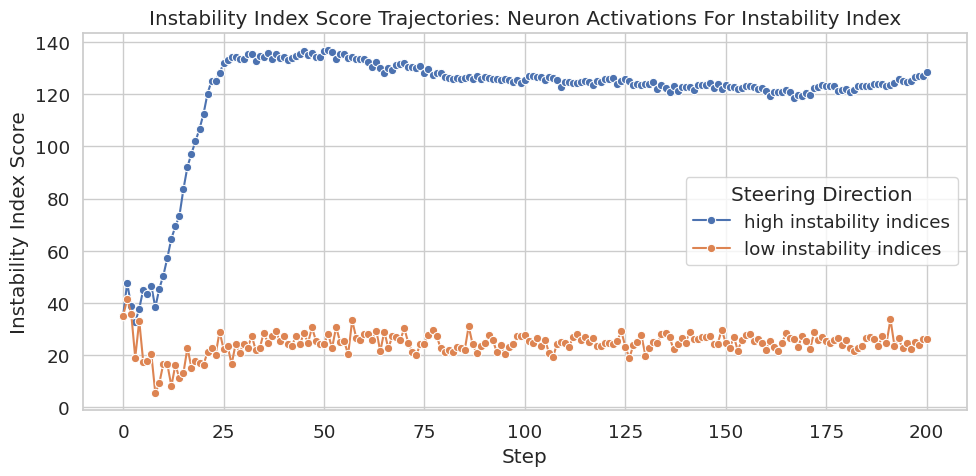

In [11]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
import random
import csv
import re
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Configuration
CSV_PATH = "esm35M_500k_neuron_explanations.csv"
MODEL_NAME = "facebook/esm2_t12_35M_UR50D"
SEQ_LEN = 300
NUM_STEPS = 200
A = 5
B = 3

# Utilities
def find_matching_neurons(csv_path, keyword):
    matches = []
    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) < 2:
                continue
            neuron_id = row[0]
            if any(keyword in desc.lower() for desc in row[1:]):
                m = re.match(r"layer_(\d+)_neuron_(\d+)", neuron_id)
                if m:
                    matches.append((int(m.group(1)), int(m.group(2))))
    return matches

def make_multi_neuron_hook(neurons, a=10.0, b=3.0):
    def hook_fn(module, input, output):
        for neuron in neurons:
            output[:, :, neuron] = a * output[:, :, neuron] + b
        return output
    return hook_fn

def random_protein_sequence(length):
    return ''.join(random.choices("ACDEFGHIKLMNPQRSTVWY", k=length))

def sample_from_logits(logits):
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).squeeze(-1)

def decode_tokens(tokenizer, token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True).replace(" ", "")

def compute_gravy_ignore_x(seq):
    cleaned = seq.replace("X", "")
    if not cleaned:
        return None
    return ProteinAnalysis(cleaned).instability_index()

# Main steering function
def steer(model, tokenizer, base_sequence, match_string, label):
    matched_neurons = find_matching_neurons(CSV_PATH, match_string)
    if not matched_neurons:
        print(f"No matching neurons found for: {match_string}")
        return []

    layer_to_neurons = defaultdict(list)
    for layer, neuron in matched_neurons:
        layer_to_neurons[layer].append(neuron)

    device = model.device
    history = []  # (step, sequence, activation, gravy)

    seq = base_sequence
    for step in tqdm(range(NUM_STEPS), desc=f"Steering for {label}"):
        inputs = tokenizer(seq, return_tensors="pt").to(device)

        handles = []
        for layer, neurons in layer_to_neurons.items():
            hook = model.base_model.encoder.layer[layer].intermediate.register_forward_hook(
                make_multi_neuron_hook(neurons, A, B)
            )
            handles.append(hook)

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits[0]
            hidden_states = outputs.hidden_states

        for h in handles:
            h.remove()

        # Score: average absolute activation across target neurons
        total, count = 0, 0
        for layer, neurons in layer_to_neurons.items():
            h = hidden_states[layer][0]
            for n in neurons:
                total += abs(h[:, n].mean().item())
                count += 1
        avg_act = total / count if count > 0 else 0

        sampled_ids = sample_from_logits(logits)
        seq = decode_tokens(tokenizer, sampled_ids)
        gravy = compute_gravy_ignore_x(seq)
        history.append((step + 1, seq, avg_act, gravy, label))

    return history

# Run both steering loops
if __name__ == "__main__":
    torch.manual_seed(42)
    random.seed(42)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
    model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
    model.eval()

    # Generate shared initial sequence
    base_sequence = random_protein_sequence(SEQ_LEN)
    print("Starting sequence:", base_sequence)

    # Run both steering directions
    history_pos = steer(model, tokenizer, base_sequence, "high instability indices", label="low instability indices")
    history_neg = steer(model, tokenizer, base_sequence, "low instability indices", label="high instability indices")
    # Add initial point (step 0) before steering
    initial_gravy = compute_gravy_ignore_x(base_sequence)
    init_row = (0, base_sequence, 0.0, initial_gravy, "high instability indices")
    history_pos = [init_row] + history_pos
    init_row = (0, base_sequence, 0.0, initial_gravy, "low instability indices")
    history_neg = [init_row] + history_neg

    # Save both to CSV
    with open("steered_sequences_dual.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["step", "sequence", "activation", "gravy", "label"])
        for row in history_pos + history_neg:
            writer.writerow(row)

    # Plot GRAVY score trajectories
    df = pd.DataFrame(history_pos + history_neg, columns=["step", "sequence", "activation", "gravy", "label"])
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x="step", y="gravy", hue="label", marker="o")
    plt.xlabel("Step")
    plt.ylabel("Instability Index Score")
    plt.title("Instability Index Score Trajectories: Neuron Activations For Instability Index")
    plt.legend(title="Steering Direction")
    plt.tight_layout()
    plt.savefig("gravy_score_comparison.png")
    
    plt.show()
